# Laboratorio 2
**Grupo 8**

Estudiantes:

- Estudiante 1 (K-Means): Luis Pinilla
- Estudiante 2 (DBScan): Alejandro Hoyos
- Estudiante 3 (Gaussian Mixture Models): Andrés Bolivar

---

In [1]:
# Imports iniciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Procesamiento
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder


# Modelos 
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

## Exploración de los datos 

En esta sección se realiza una exploración inicial del dataset con el objetivo de entender su estructura, calidad y posibles problemas que deban ser abordados en la preparación posterior.

### 1. Vista general

- Dimensiones del dataset (`.shape`).
- Tipos de variables (`.dtypes`).
- Primeras filas (`.head()`).
- Identificación de columnas numéricas y categóricas.

---

Conclusiones

- El dataset contiene **14,291 observaciones** (filas), donde cada fila corresponde a un grano fotografeado.
- Se tienen **19 variables** (columnas) que describen características morfológicas y de proceso del grano.
- La mayoría de las variables son **numéricas** (área, perímetro, ejes, factores de forma, etc.), lo que facilita aplicar algoritmos de clustering.
- Existe una columna `ID` que funciona como identificador único por grano, útil para trazabilidad pero que no debe usarse en el modelado.
- Se observan variables **categóricas** (`RelacionAspecto`, `DefectoVisible`, `MétodoSecado`), que requerirán **codificación o transformación** antes de ser usadas.
- Viendo solo el head se pueden ver **valores nulos** en algunas columnas (ej. `Excentricidad`, `AreaConvexa`, `DiametroEquivalente`), lo cual será un punto clave en la preparación de los datos.
- En `RelacionAspecto` se aprecian posibles inconsistencias de formato (ej. "alargado" vs "Alargado"), lo que requerirá normalización.



In [2]:
data = pd.read_csv("data/Datos_SenecaféAlpes.csv", sep = ";")
data.head()

,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
0,G006149,50836,923618.0,358.515147,181.388899,alargado,NaN,NaN,254.413847,0.804762,0.983840,0.748853,0.709632,0.007052,0.001103,0.503578,0.995321,Normal,Lavado
1,G007234,62764,1003767.0,409.207082,198.330199,Alargado,NaN,64158.0,282.689948,0.703995,0.978272,0.782807,0.690824,0.006520,0.000916,0.477237,0.984666,NaN,Natural
2,G007054,59965,994266.0,389.088529,197.967275,Alargado,0.860886,60910.0,276.314692,0.661581,0.984485,0.762259,0.710159,0.006489,0.001018,0.504326,0.991211,Normal,Natural
3,G006619,55035,917.6,379.346822,185.390577,Alargado,0.872446,55591.0,NaN,0.799695,0.989998,0.821376,0.697811,0.006893,0.001008,0.486941,0.996380,Normal,Lavado
4,G013353,39324,737773.0,262.520242,191.176858,Alargado,0.685326,39758.0,223.760747,0.775392,0.989084,0.907867,0.852356,0.006676,0.002174,0.726511,0.997630,Normal,Lavado


In [3]:
data.shape

(14291, 19)

In [4]:
data.dtypes

ID                      object
Area                     int64
Perimetro              float64
LongitudEjeMayor       float64
LongitudEjeMenor       float64
RelacionAspecto         object
Excentricidad          float64
AreaConvexa            float64
DiametroEquivalente    float64
Medida                 float64
Solidez                float64
Redondez               float64
Compacidad             float64
FactorForma1           float64
FactorForma2           float64
FactorForma3           float64
FactorForma4           float64
DefectoVisible          object
MétodoSecado            object
dtype: object


### 2. Duplicados y fila ID


- Verificar unicidad de la columna `ID`. (Verificar que cada grano de café se haya medido una única vez)
- Verificar si los duplicados son idénticos o solo en el id (verificar si son diferentes mediciones del mismo grano o un duplicado full)
---

**Conclusiones**

- El dataset contiene **14,291 filas en total**.
- Se encontraron **680 filas con IDs duplicados**.
- De estas, **461 son duplicados exactos** (todas las columnas idénticas).
- La diferencia restante corresponde a casos donde el `ID` se repite, pero con variaciones en alguna de sus características (posibles mediciones múltiples del mismo grano).
- Dado que el dataset es grande, podemos **eliminar duplicados de ID** sin comprometer la cantidad de datos disponible para el clustering.
- Verificamos que las columnas de FactorForma, no sean columnas con la misma información. Pero factor foram 2 y FactorForma3 sí son reduntades con una correlaci´ón de 0.85. podríamos considerar eliminar alguna. 
- Para ello, podemos usar la lista que demaos ede duplicados por id:

```python
duplicados_id = data["ID"].duplicated().sum()

In [5]:
duplicados_id = data["ID"].duplicated().sum()
total_ids = data["ID"].unique()
total_filas = data.shape[0]


print(f"Total de filas: {total_filas}")
print(f"Total de IDs únicos: {total_ids}")
print(f"IDs duplicados: {duplicados_id}")

Total de filas: 14291
Total de IDs únicos: ['G006149' 'G007234' 'G007054' ... 'G005391' 'G000861' 'G007271']
IDs duplicados: 680


In [6]:
# Duplicados exactos (todas las columnas iguales) 
duplicados_exactos = data.duplicated().sum()
print(f"Duplicados exactos: {duplicados_exactos}")

# Duplicados solo en el ID (aunque difieran en otras columnas) BIEN IMPORTANTE PARA FUTUROS PASOS
duplicados_id = data.duplicated(subset=["ID"]).sum()
print(f"Duplicados de ID (no necesariamente exactos): {duplicados_id}")

Duplicados exactos: 461
Duplicados de ID (no necesariamente exactos): 680


In [7]:
# Comparar columnas entre sí
for i in range(1, 5):
    for j in range(i+1, 5):
        iguales = (data[f"FactorForma{i}"] == data[f"FactorForma{j}"]).all()
        print(f"FactorForma{i} vs FactorForma{j}: {'idénticas' if iguales else 'diferentes'}")

FactorForma1 vs FactorForma2: diferentes
FactorForma1 vs FactorForma3: diferentes
FactorForma1 vs FactorForma4: diferentes
FactorForma2 vs FactorForma3: diferentes
FactorForma2 vs FactorForma4: diferentes
FactorForma3 vs FactorForma4: diferentes


In [8]:
corr_factores = data[["FactorForma1", "FactorForma2", "FactorForma3", "FactorForma4"]].corr()
print(corr_factores)

              FactorForma1  FactorForma2  FactorForma3  FactorForma4
FactorForma1      1.000000      0.448304     -0.004989      0.025435
FactorForma2      0.448304      1.000000      0.856565      0.054917
FactorForma3     -0.004989      0.856565      1.000000      0.050293
FactorForma4      0.025435      0.054917      0.050293      1.000000



### 3. Valores nulos y faltantes
 

- Conteo de valores nulos por columna.
- Porcentaje de nulos respecto al total.
- Identificación de patrones de nulos.

--- 
**Conclusiones**
- Varias columnas presentan valores faltantes en proporciones variadas:
  - Solidez (16%), Redondez (14%), DiámetroEquivalente (13%) y DefectoVisible (20%) son las más afectadas.
  - Otras columnas tienen porcentajes menores de nulos (entre 2% y 9%), lo que puede manejarse con imputación sin tanto problema.
- El heatmap confirma que los nulos están presentes en mayor cantidad en algunas de las columnas.
- El dataset es grande (14,291 filas), pero eliminar todas las filas con nulos podría reducir demasiado la información en ciertas variables clave.

Para el tratamiento:
- Todas las variables con nulos son **numéricas** excepto **DefectoVisible** y **MétodoSecado**.  
- En variables numéricas, lo más práctico es imputar con la **mediana**, ya que:  
  - Es robusta frente a outliers.  
  - Mantiene la escala de los datos sin sesgar la distribución.  
- En variables categóricas (**DefectoVisible**, **MétodoSecado**), se puede:  
  - Reemplazar los nulos con la categoría más frecuente (moda).  
  - Aunque para DefectoVisible, lo mejor quizá sea elimiarlo, ya que al contar con tantos nulos, nos puede generar un cluster artificial.  
- Con esta estrategia se garantiza que ninguna fila se elimina y todo el dataset puede usarse en los algoritmos de clustering. 

In [9]:
# Conteo de valores nulos por columna
nulos_totales = data.isnull().sum()
print(nulos_totales)

ID                        0
Area                      0
Perimetro              1237
LongitudEjeMayor        401
LongitudEjeMenor          0
RelacionAspecto         466
Excentricidad           604
AreaConvexa            1423
DiametroEquivalente    1923
Medida                    0
Solidez                2306
Redondez               2063
Compacidad              650
FactorForma1           1119
FactorForma2           1106
FactorForma3            478
FactorForma4           1159
DefectoVisible         2935
MétodoSecado            587
dtype: int64


In [10]:
# Porcentaje de nulos respecto al total de filas
nulos_porcentaje = (nulos_totales / data.shape[0]) * 100
print(nulos_porcentaje)


ID                      0.000000
Area                    0.000000
Perimetro               8.655797
LongitudEjeMayor        2.805962
LongitudEjeMenor        0.000000
RelacionAspecto         3.260794
Excentricidad           4.226436
AreaConvexa             9.957316
DiametroEquivalente    13.456021
Medida                  0.000000
Solidez                16.136030
Redondez               14.435659
Compacidad              4.548317
FactorForma1            7.830103
FactorForma2            7.739137
FactorForma3            3.344762
FactorForma4            8.109999
DefectoVisible         20.537401
MétodoSecado            4.107480
dtype: float64


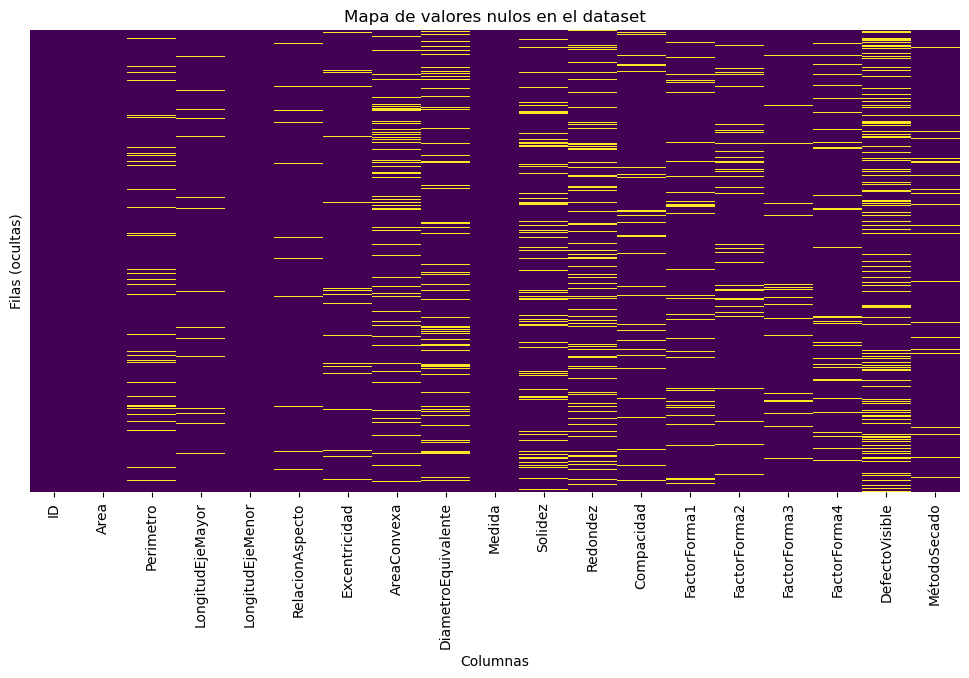

In [11]:


plt.figure(figsize=(12,6))
sns.heatmap(data.isnull(), 
            cbar=False, 
            cmap="viridis", 
            yticklabels=False)

plt.title("Mapa de valores nulos en el dataset")
plt.xlabel("Columnas")
plt.ylabel("Filas (ocultas)")
plt.show()



### 4. Estadísticos descriptivos y outliers


Como la mayoría de nuestros datos son numéricos, hacer un análisis de este típo de métricas puede llegar a ser bien útil

- Medidas de tendencia central y dispersión (`.describe()`).
- Rango, mínimo, máximo y valores atípicos evidentes.
- Outliers por z-score 
- Detección gráfica de outliers

---

**Conclusiones**


- Los estadísticos descriptivos muestran que algunas variables presentan **valores negativos en métricas como área y perímetro, lo cual no es físicamente posible**. Estos registros deben ser corregidos o eliminados.
- Se detectaron **centenares de outliers** en variables clave como Área, Perímetro, Longitudes de Eje, Área Convexa y Diámetro Equivalente. En promedio, afectan entre el 2% y 4% de los registros, lo cual es relevante pero no crítico en un dataset de más de 14 mil filas.
- La detección visual con boxplots confirma colas largas y valores extremos especialmente en métricas geométricas, mientras que atributos como Solidez, Compacidad y Factores de Forma son más estables.
- Para el modelado:
  - **K-Means** es altamente sensible a estos outliers debido a su dependencia de la distancia euclidiana. Sin un tratamiento adecuado (eliminación de valores imposibles y uso de escalado robusto), los centroides pueden distorsionarse.
  - **DBSCAN** es más tolerante porque trata valores extremos como ruido natural del dataset. Por esta razón, mantener algunos outliers puede incluso ayudar a identificar patrones de anomalías.
- En conclusión, recomendado  **eliminar registros con valores físicamente imposibles** y aplicar un **escalado robusto** en lugar de eliminar sistemáticamente todos los outliers. Esto equilibra la preparación de los datos para que tanto K-Means como DBSCAN funcionen de manera adecuada sin perder información valiosa sobre granos atípicos.


In [12]:
# Seleccionar  numéricas (BIEN IMPORTANTE PARA LOS DEMAS PASOS)
numericas = data.select_dtypes(include=["int64", "float64"])

# Estadísticos 
desc_stats = numericas.describe().T  
display(desc_stats)

,count,mean,std,min,25%,50%,75%,max
Area,14291.0,53055.408999,29396.080372,-6.271600e+04,36338.000000,44660.000000,61311.000000,2.546160e+05
Perimetro,13054.0,772986.954791,326649.281155,-1.012143e+06,676860.750000,772034.500000,955409.750000,1.921685e+06
LongitudEjeMayor,13890.0,319.985592,86.378452,-4.214447e+02,253.319858,296.682345,376.548109,7.388602e+02
LongitudEjeMenor,14291.0,202.178613,45.494541,-2.008387e+02,175.881052,192.437870,216.847844,4.601985e+02
Excentricidad,13687.0,0.749977,0.099438,-8.350038e-01,0.715144,0.764392,0.810441,9.114230e-01
AreaConvexa,12868.0,53575.397809,29566.387814,-7.842300e+04,36720.000000,45107.500000,62109.250000,2.510820e+05
DiametroEquivalente,12368.0,253.001741,60.542330,-4.484026e+02,215.302463,238.579492,279.672481,5.693744e+02
Medida,14291.0,0.749844,0.050774,-7.987057e-01,0.718767,0.760232,0.786942,8.661946e-01
Solidez,11985.0,0.986774,0.025947,-9.890416e-01,0.985597,0.988279,0.989991,9.943782e-01
Redondez,12228.0,0.873080,0.063237,-8.968612e-01,0.832824,0.883353,0.916803,9.906854e-01


In [13]:
z_scores = (numericas - numericas.mean()) / numericas.std()
outliers = (np.abs(z_scores) > 3).sum() # BIEN IMPORTANTE PARA PASOS FUTUROS 

print("Número de outliers por variable (|z|>3):")
print(outliers)

Número de outliers por variable (|z|>3):
Area                   513
Perimetro               48
LongitudEjeMayor       318
LongitudEjeMenor       538
Excentricidad           87
AreaConvexa            447
DiametroEquivalente    420
Medida                 103
Solidez                  2
Redondez                52
Compacidad               4
FactorForma1            27
FactorForma2            10
FactorForma3             9
FactorForma4             5
dtype: int64


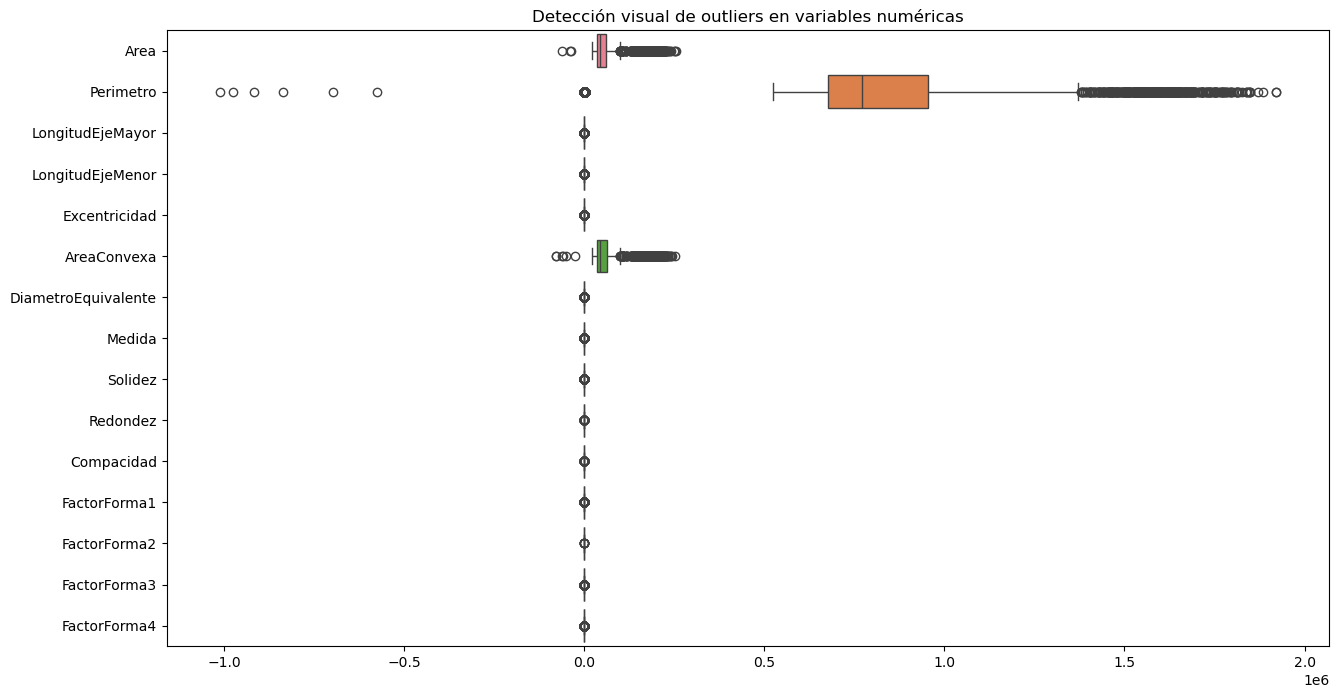

In [14]:
plt.figure(figsize=(15,8))
sns.boxplot(data=numericas, orient="h")
plt.title("Detección visual de outliers en variables numéricas")
plt.show()


### 5. Distribuciones


- Histogramas para cada variable numérica.
- Conteos para variables categóricas.
- Histogramas de variables Categóricas 

---
**Conclusiones**
- Las variables numéricas muestran distribuciones sesgadas, con colas largas y varios outliers, especialmente en Área, Perímetro, ÁreaConvexa y DiámetroEquivalente.  
- En variables como Solidez y FactorForma4 la distribución está prácticamente concentrada en un único valor, lo que indica que aportan poca variabilidad y pueden eliminarse del análisis.  
- En las variables categóricas se observa que hay diferencias de categorías solo por mayúsculas y minúsculas, lo cual debe normalizarse para evitar duplicados falsos.  
- DefectoVisible no aporta información relevante: casi todos los registros son "Normal" o nulos, por lo que puede eliminarse sin perder valor para el clustering.  
- RelacionAspecto y MétodoSecado sí muestran mayor diversidad de categorías, por lo que pueden conservarse tras normalización y codificación adecuada.



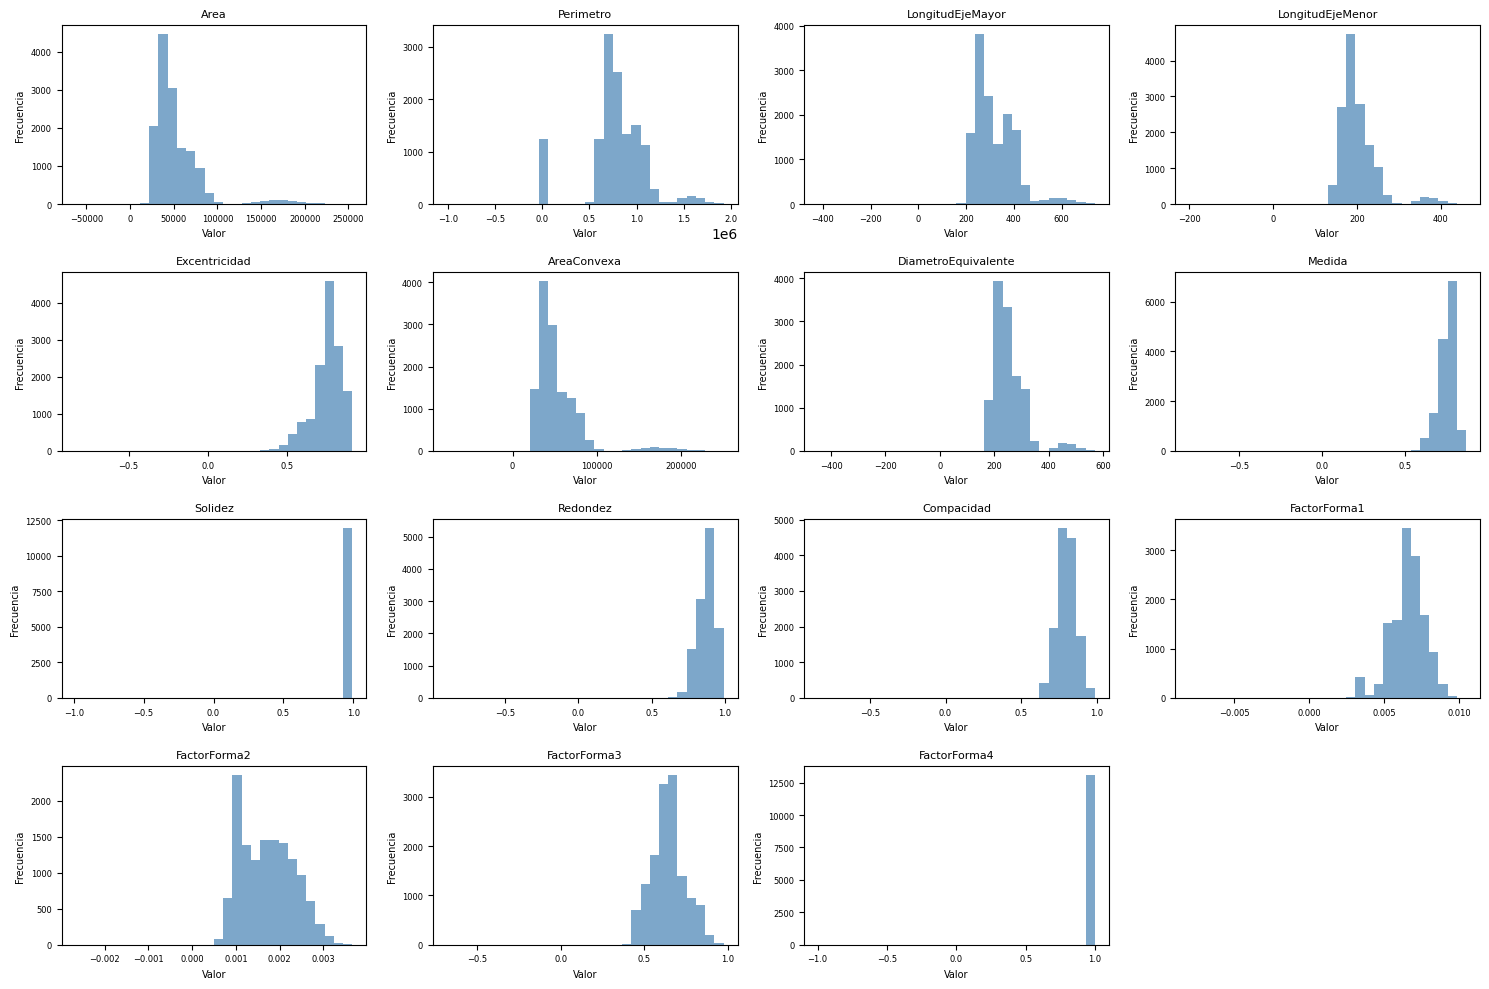

In [15]:
#  Histogramas para variables numéricas
num_cols = numericas.shape[1]
cols = 4  
rows = (num_cols // cols) + 1

plt.figure(figsize=(15,10))


for i, col in enumerate(numericas.columns, 1):
    plt.subplot(rows, cols, i)
    plt.hist(data[col].dropna(), bins=30, color="steelblue", alpha=0.7)
    plt.title(col, fontsize=8)
    plt.xlabel("Valor", fontsize=7)
    plt.ylabel("Frecuencia", fontsize=7)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

plt.tight_layout()
plt.show()

In [16]:
# Seleccionar variables categóricas
categoricas = data.select_dtypes(include=["object"])

# Conteo de frecuencias para cada variable categórica
for col in categoricas.columns:
    print(f"\n=== {col} ===")
    print(data[col].value_counts(dropna=False))


=== ID ===
ID
G002981    2
G006097    2
G005497    2
G011441    2
G008205    2
          ..
G006950    1
G010584    1
G000770    1
G001686    1
G005406    1
Name: count, Length: 13611, dtype: int64

=== RelacionAspecto ===
RelacionAspecto
Alargado      12047
Redondeado     1739
NaN             466
alargado         29
redondeado       10
Name: count, dtype: int64

=== DefectoVisible ===
DefectoVisible
Normal    9096
NaN       2935
normal    2260
Name: count, dtype: int64

=== MétodoSecado ===
MétodoSecado
Lavado     6260
Natural    4639
lavado     1552
natural    1176
NaN         587
Honey        64
honey        13
Name: count, dtype: int64


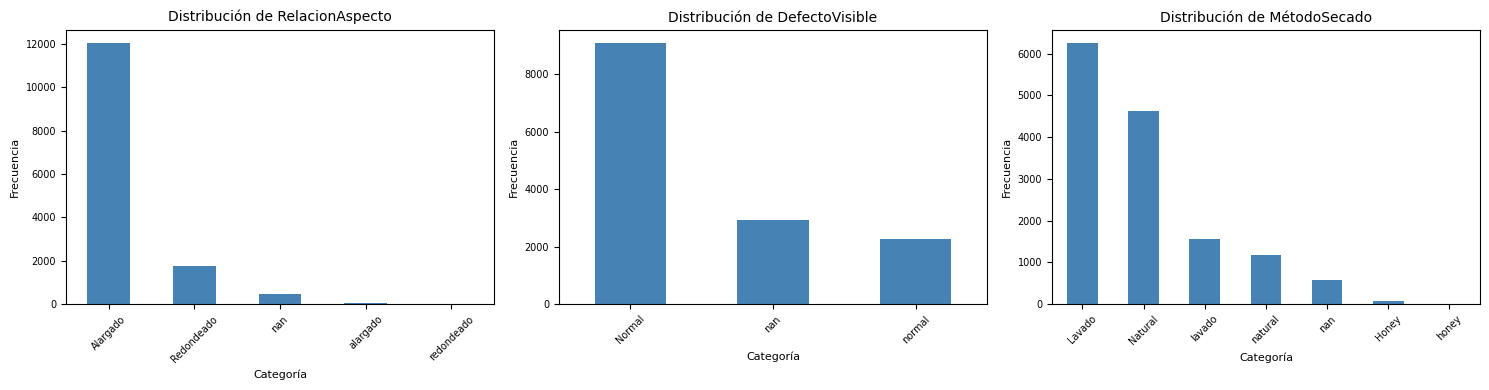

In [17]:

categoricas = ["RelacionAspecto", "DefectoVisible", "MétodoSecado"]

plt.figure(figsize=(15,4))

for i, col in enumerate(categoricas, 1):
    plt.subplot(1, 3, i)  # una fila, 3 columnas
    data[col].value_counts(dropna=False).plot(kind="bar", color="steelblue")
    plt.title(f"Distribución de {col}", fontsize=10)
    plt.xlabel("Categoría", fontsize=8)
    plt.ylabel("Frecuencia", fontsize=8)
    plt.xticks(rotation=45, fontsize=7)
    plt.yticks(fontsize=7)

plt.tight_layout()
plt.show()

### 6. Correlaciones iniciales


- Matriz de correlación entre variables numéricas.
- Identificación de pares de variables altamente correlacionadas.

---

**Conclusiones**

- Se observan altas correlaciones positivas entre las variables geométricas: Área, Perímetro, ÁreaConvexa y DiámetroEquivalente. También LongitudEjeMayor y LongitudEjeMenor correlacionan fuertemente con ellas, indicando redundancia de información.
- Algunas variables de forma como Compacidad, Redondez y Excentricidad muestran correlaciones moderadas o negativas, lo cual aporta diversidad y puede ser útil para distinguir granos.
- Los Factores de Forma presentan correlaciones altas entre sí, especialmente FactorForma2, FactorForma3 y FactorForma4, lo que sugiere que varios de ellos aportan información muy similar.
- Solidez y FactorForma4 presentan valores casi constantes y por tanto su aporte al clustering es muy bajo.

**Influencia en algoritmos de agrupamiento**
- En K-Means, las variables altamente correlacionadas pueden sesgar la construcción de centroides porque la misma información pesa varias veces. Por eso conviene reducir la redundancia eliminando variables o aplicando PCA.
- En DBSCAN, la redundancia afecta menos ya que el algoritmo trabaja con densidades, aunque igualmente puede inflar la dimensionalidad y hacer más costoso el cálculo de distancias.
- En algoritmos jerárquicos o Gaussian Mixture Models, la correlación también puede distorsionar las distancias y hacer que algunos clusters aparezcan artificialmente más compactos o separados.

**Recomendaciones**
- Eliminar o consolidar variables geométricas redundantes, manteniendo solo las más representativas.
- Revisar los Factores de Forma y reducirlos para evitar duplicación de información.
- Mantener variables que aportan contraste (como Excentricidad, Redondez y Compacidad).
- Como criterio práctico,  eliminaríamos Solidez y FactorForma4 por su baja variabilidad, y de las variables geométricas altamente correlacionadas me quedaría solo con Área y DiámetroEquivalente para representar tamaño sin redundancia.



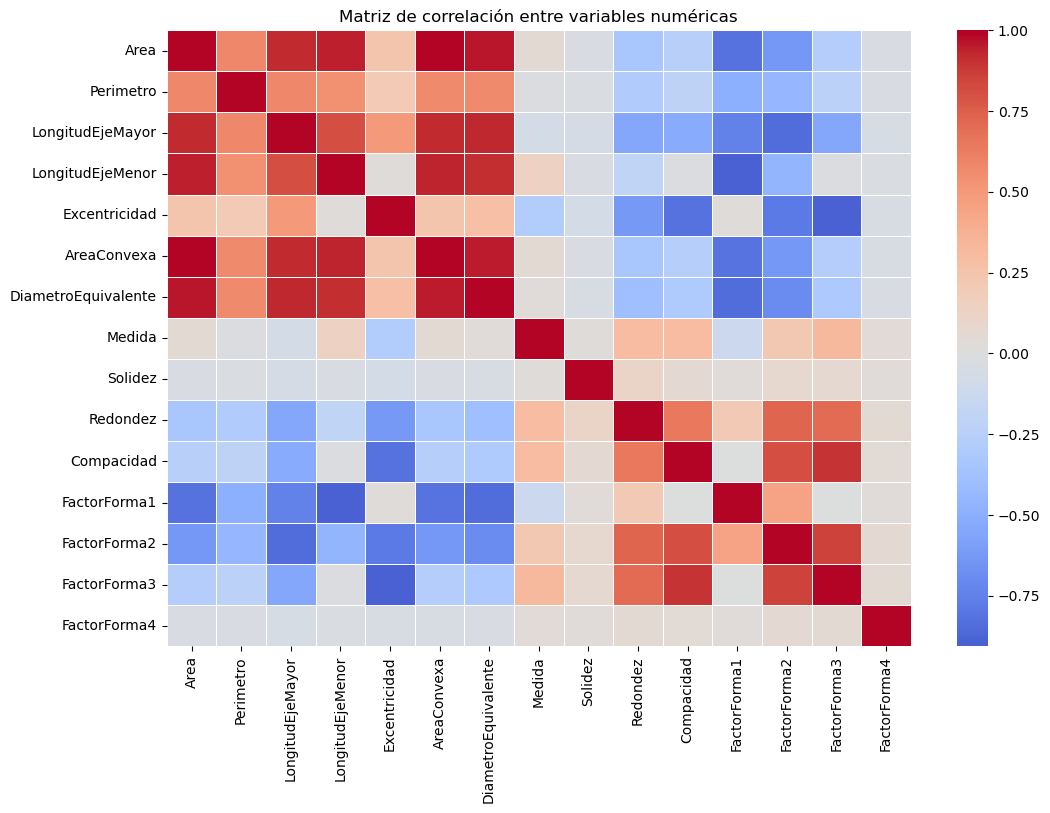

In [18]:
# Calcular matriz de correlación
corr = numericas.corr()

# Heatmap de correlaciones
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, linewidths=0.5)
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

## Procesamiento Genérico de los datos 
- Por genérico, nos referimos a que aplica para cualquiera de los modelos a implementar



In [19]:
#Un dataframe nuevo para comparar los resultados de limpieza vs los sucios
cleanData = data.copy()


### 1. **Duplicados**



   - Eliminar los duplicados exactos y aquellos con IDs repetidos.  

---
**Resultados**

- Eliminamos 680 filas duplicadas

In [20]:
# Eliminar duplicados exactos
cleanData.drop_duplicates()

# Eliminar duplicados de ID (aunque tengan diferencias en otras columnas)
cleanData = cleanData.drop_duplicates(subset=["ID"], keep = "first")

# Prints pa ver que pasó.
duplicados_id = cleanData["ID"].duplicated().sum()
print(f"Número de IDs duplicados restantes: {duplicados_id}")
print(f"Filas originales: {data.shape[0]}\nFilas después de limpieza: {cleanData.shape[0]}\nDiferencia: {data.shape[0]-cleanData.shape[0]}")

Número de IDs duplicados restantes: 0
Filas originales: 14291
Filas después de limpieza: 13611
Diferencia: 680


### 2. **Manejo de Nulos (categóricas y numéricas)**

   - Imputar las variables numéricas con la **mediana** para mantener robustez frente a outliers.  
   - En variables categóricas Normalizar y manejar nulos:
     - RelaciónAspecto : unificar categorías en minúscula y corregir inconsistencias. Los nulos se pueden imputar con la moda o ahí miramos.
     - MétodoSecado :unificar categorías en minúscula y corregir inconsistencias. Los nulos se pueden imputar con la moda o ahí miramos.  
     - DefectoVisible :  debido a su alta proporción de nulos (~20%) y solo tener una clase "Normal" decidimos borrar la columna.  


---

**Resultado**

- Las variables numéricas ya no tienen nulos 
- Las columnas categóricas del dataset se normalizaron: ya no cuentan Normal y normal como tipos de dato diferentes.
- Puesto que en la columna de DefectoVisible,  todos los tipos de dato eran "Normal" o nulo, no tiene sentido incluirlo, ya que no añade diferenciación a los datos. Eliminamos esa columna completamente.
- Ya que el resto de las columnas con valores nulos representan menos de 1k registros, el dataset igual puede manejar esta pérdida y los datos ya quedarían completemente sin nulos.. por eso decidimos quitarlos ya que manejarlos con la moda puede sesgar el algoritmo ya que estaríamos inflado la clase mayotiratria. 
- Respecto al dataset original (14291 entradas) únicamente perdimos 1663 filas que sigue siendo un lujo que nos podemos dar


In [21]:

# columnas numéricas
num_cols = cleanData.select_dtypes(include=["int64", "float64"]).columns

# Imputar valores nulos con la mediana
for col in num_cols:
    mediana = cleanData[col].median()
    cleanData[col] = cleanData[col].fillna(mediana)

# Verificar 
print("Las variables numéricas ya no deberían tener valores nulos:")
print(cleanData.isnull().sum())

Las variables numéricas ya no deberían tener valores nulos:
ID                        0
Area                      0
Perimetro                 0
LongitudEjeMayor          0
LongitudEjeMenor          0
RelacionAspecto         443
Excentricidad             0
AreaConvexa               0
DiametroEquivalente       0
Medida                    0
Solidez                   0
Redondez                  0
Compacidad                0
FactorForma1              0
FactorForma2              0
FactorForma3              0
FactorForma4              0
DefectoVisible         2781
MétodoSecado            558
dtype: int64


In [22]:
# Pasar a minúsculas las tres columnas categóricas
categoricas = ["RelacionAspecto", "MétodoSecado", "DefectoVisible"]

for col in categoricas:
    cleanData[col] = cleanData[col].astype(str).str.lower()

# Verificar los valores únicos después de la transformación
for col in categoricas:
    print(f"\nColumna: {col}")
    print(cleanData[col].unique())


Columna: RelacionAspecto
['alargado' 'redondeado' 'nan']

Columna: MétodoSecado
['lavado' 'natural' 'nan' 'honey']

Columna: DefectoVisible
['normal' 'nan']


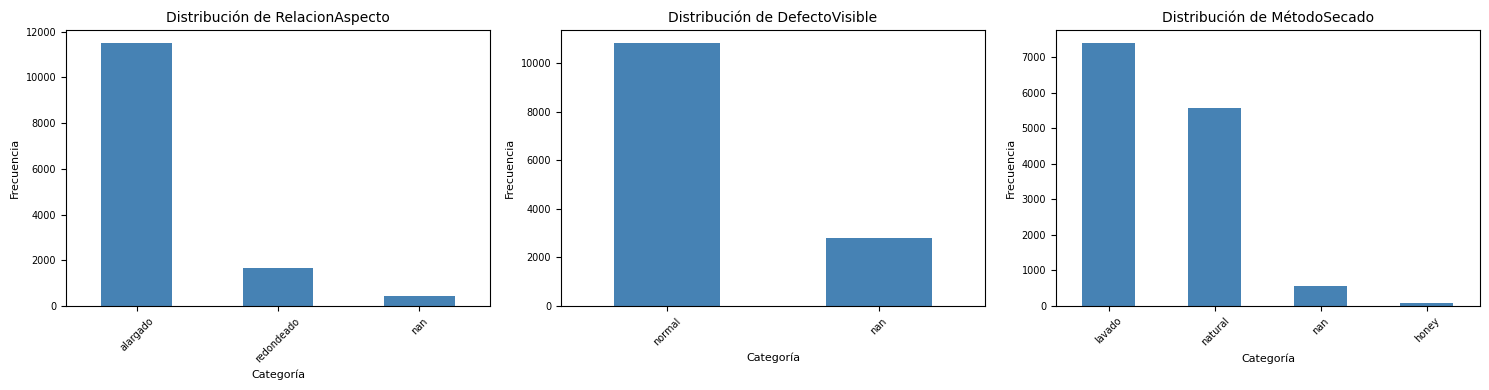

In [23]:
categoricas = ["RelacionAspecto", "DefectoVisible", "MétodoSecado"]

plt.figure(figsize=(15,4))

for i, col in enumerate(categoricas, 1):
    plt.subplot(1, 3, i)  # una fila, 3 columnas
    cleanData[col].value_counts(dropna=False).plot(kind="bar", color="steelblue")
    plt.title(f"Distribución de {col}", fontsize=10)
    plt.xlabel("Categoría", fontsize=8)
    plt.ylabel("Frecuencia", fontsize=8)
    plt.xticks(rotation=45, fontsize=7)
    plt.yticks(fontsize=7)

plt.tight_layout()
plt.show()

In [24]:
# Reconvertir cadenas "nan" (string) a NaN real
cleanData[["RelacionAspecto", "MétodoSecado", "DefectoVisible"]] = cleanData[["RelacionAspecto", "MétodoSecado", "DefectoVisible"]].replace("nan", np.nan)
# Revisar nulos en las columnas categóricas relevantes
print(cleanData[["RelacionAspecto", "MétodoSecado", "DefectoVisible"]].isnull().sum())

# También ver la proporción sobre el total
total_filas = cleanData.shape[0]
print("\nProporción de nulos:")
print((cleanData[["RelacionAspecto", "MétodoSecado", "DefectoVisible"]].isnull().sum() / total_filas) * 100)

RelacionAspecto     443
MétodoSecado        558
DefectoVisible     2781
dtype: int64

Proporción de nulos:
RelacionAspecto     3.254720
MétodoSecado        4.099625
DefectoVisible     20.432004
dtype: float64


In [25]:
# Eliminar la columna DefectoVisible
cleanData = cleanData.drop(columns=["DefectoVisible"])

# Prints pa ver que pasó.
print(f"Número de IDs duplicados restantes: {duplicados_id}")
print(f"Columnas originales: {data.shape[1]}\nColumnas después de limpieza: {cleanData.shape[1]}\nDiferencia: {data.shape[1]-cleanData.shape[1]}")


Número de IDs duplicados restantes: 0
Columnas originales: 19
Columnas después de limpieza: 18
Diferencia: 1


In [26]:
# Eliminar filas con nulos en RelacionAspecto y MétodoSecado
cleanData = cleanData.dropna(subset=["RelacionAspecto", "MétodoSecado"])

# Verificar resultado
print(f"Filas después de eliminar nulos categóricos: {cleanData.isnull().sum()}")




Filas después de eliminar nulos categóricos: ID                     0
Area                   0
Perimetro              0
LongitudEjeMayor       0
LongitudEjeMenor       0
RelacionAspecto        0
Excentricidad          0
AreaConvexa            0
DiametroEquivalente    0
Medida                 0
Solidez                0
Redondez               0
Compacidad             0
FactorForma1           0
FactorForma2           0
FactorForma3           0
FactorForma4           0
MétodoSecado           0
dtype: int64


In [27]:
# Prints pa ver que pasó.
print(f"Filas originales: {data.shape[0]}\nFilas después de limpieza: {cleanData.shape[0]}\nDiferencia: {data.shape[0]-cleanData.shape[0]}")

cleanData.shape

Filas originales: 14291
Filas después de limpieza: 12628
Diferencia: 1663


(12628, 18)


### 3. **Valores imposibles o negativos**


   - Se detectaron valores negativos en métricas geométricas (ej. Área y Perímetro) que no son físicamente posibles. 
   - Además si revisamos la descripción del excel de las variables numérias, ninguna de estas medidas debería ser negativa. 
   - Corregir si se trata de error de digitación, o en su defecto eliminar esas filas. 
  
  ---
**Resultados**

- Se encontraron 57 filas con al menos un valor negativo (datos imposibles)
- Vimos que todos estos datos son bastante similares a los valores de media, comparamos con la desviación estándar. Entonces decidimos dejarlos pero en valor aboluto. 
- Ya no existen valores imposibles en nuestros datos.

In [28]:
# columnas numéricas
num_cols = cleanData.select_dtypes(include=["int64", "float64"]).columns
print(num_cols)

Index(['Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor',
       'Excentricidad', 'AreaConvexa', 'DiametroEquivalente', 'Medida',
       'Solidez', 'Redondez', 'Compacidad', 'FactorForma1', 'FactorForma2',
       'FactorForma3', 'FactorForma4'],
      dtype='object')


In [29]:
# Contar cuántos valores negativos hay en cada columna
negativos = (cleanData[num_cols] < 0).sum()
print("Número de valores negativos por columna:\n", negativos)

# Filtrar filas que tienen al menos un valor negativo
filas_negativas = cleanData[(cleanData[num_cols] < 0).any(axis=1)]
print(f"\nNúmero de filas con al menos un valor negativo: {filas_negativas.shape[0]}")

# Mostrar algunas filas problemáticas
display(filas_negativas.head())

Número de valores negativos por columna:
 Area                   3
Perimetro              5
LongitudEjeMayor       3
LongitudEjeMenor       4
Excentricidad          8
AreaConvexa            3
DiametroEquivalente    4
Medida                 1
Solidez                2
Redondez               1
Compacidad             4
FactorForma1           5
FactorForma2           6
FactorForma3           3
FactorForma4           5
dtype: int64

Número de filas con al menos un valor negativo: 57


,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,MétodoSecado
372,G004395,70912,-1012143.0,371.718651,244.678403,alargado,0.752812,71891.0,300.479554,0.761880,0.986382,0.869853,0.808352,0.005242,0.001381,0.653433,0.992704,lavado
406,G003257,85505,1160758.0,432.154231,253.682141,alargado,-0.809574,87053.0,329.952038,0.739381,0.982218,0.797477,0.763505,0.005054,0.001059,0.582940,0.993054,natural
1062,G007607,38055,743589.0,275.332707,177.147725,alargado,0.765534,38618.0,220.120719,0.689977,0.985421,0.864880,0.799472,-0.007235,0.001823,0.639155,0.993410,natural
1334,G002535,66985,771851.0,340.088256,251.151702,alargado,0.674265,68137.0,292.041009,0.729764,0.988275,0.826573,0.858721,0.005077,0.001703,0.737402,-0.998527,natural
1804,G003483,157119,1483123.0,530.002228,379.431894,alargado,0.698196,158406.0,238.570152,0.773871,0.991875,0.897603,-0.843901,0.003373,0.001055,0.712170,0.994781,lavado


In [30]:
# Revisar valores negativos y compararlos con la mediana y desviación estándar
for col in num_cols:
    negativos_col = cleanData[cleanData[col] < 0][col]
    if len(negativos_col) > 0:
        media = cleanData[col].mean()
        mediana = cleanData[col].median()
        std = cleanData[col].std()

        print(f"\nColumna: {col}")
        print(f"Valores negativos encontrados:\n{negativos_col.values}")
        print(f"Media: {media:.2f}, Mediana: {mediana:.2f}, Desviación estándar: {std:.2f}")

        # Distancia en sigmas de cada valor negativo respecto a la media
        distancias = (negativos_col - media) / std
        print("Distancia en desviaciones estándar (z-score):")
        print(distancias.values)


Columna: Area
Valores negativos encontrados:
[-38311 -62716 -36171]
Media: 52993.73, Mediana: 44579.50, Desviación estándar: 29411.62
Distancia en desviaciones estándar (z-score):
[-3.10437635 -3.93415051 -3.03161599]

Columna: Perimetro
Valores negativos encontrados:
[-1012143.  -974886.  -575308.  -915659.  -697382.]
Media: 771712.53, Mediana: 771851.00, Desviación estándar: 313190.97
Distancia en desviaciones estándar (z-score):
[-5.69574386 -5.57678449 -4.30095587 -5.38767623 -4.69073084]

Columna: LongitudEjeMayor
Valores negativos encontrados:
[-421.4446574 -243.3752477 -397.1658639]
Media: 319.00, Mediana: 296.52, Desviación estándar: 85.19
Distancia en desviaciones estándar (z-score):
[-8.69186671 -6.60157267 -8.40686651]

Columna: LongitudEjeMenor
Valores negativos encontrados:
[-189.8428757 -200.838672  -188.5903078 -198.0582728]
Media: 202.11, Mediana: 192.43, Desviación estándar: 45.58
Distancia en desviaciones estándar (z-score):
[-8.59999538 -8.8412557  -8.57251261 -8.78

In [31]:
# Pasar a valor absoluto todas las columnas que no deberían ser negativas
cleanData[num_cols] = cleanData[num_cols].abs()

# Verificar que ya no queden negativos
negativos_post = (cleanData[num_cols] < 0).sum()
print("Número de valores negativos después de corrección:\n", negativos_post)

Número de valores negativos después de corrección:
 Area                   0
Perimetro              0
LongitudEjeMayor       0
LongitudEjeMenor       0
Excentricidad          0
AreaConvexa            0
DiametroEquivalente    0
Medida                 0
Solidez                0
Redondez               0
Compacidad             0
FactorForma1           0
FactorForma2           0
FactorForma3           0
FactorForma4           0
dtype: int64


 ### 4. **Escalado y Outliers** 

   - Confirmados por z-score e inspección gráfica.  
   - Estrategia: no eliminarlos sistemáticamente, sino usar un **escalado robusto** que reduzca su impacto en K-Means sin perder la información útil para DBSCAN.  

---

**Resultados**

- Se detectaron valores atípicos en variables geométricas como Área, Perímetro y Diámetro Equivalente. **Decidmmos escalar para que los algoritmos que usan distancias no se vean perjudicados por outliers**. 
- En un problema de regresión o clasificación se eliminarían para no sesgar la predicción. Sin embargo, en **clustering su papel es distinto**:  
  - En **K-Means**, los outliers pueden mover los centroides, pero al usar un escalado robusto reducimos su influencia sin necesidad de descartarlos.  
  - En **DBSCAN**, los outliers son parte del valor del algoritmo, ya que se reconocen como ruido o puntos aislados, ayudando a separar mejor los clusters.  
- Por lo tanto, eliminarlos de forma sistemática haría que el modelo **pierda capacidad para detectar casos extremos o ruido**, lo que es información valiosa en clustering.  
- Se decidió conservarlos, aplicando un escalado robusto para estabilizar K-Means y permitir que DBSCAN aproveche esa variabilidad.   


#### Justificación de RobustScaler
- Existen outliers confirmados en varias variables.  
- No queremos eliminarlos porque DBSCAN puede considerarlos ruido informativo.  
- K-Means es muy sensible a valores extremos, por lo que robustecer la escala evita que los centroides se desvíen.  

#### Otras formas de escalado a considerar

- **StandardScaler (Z-score):** centra los datos en media 0 y varianza 1. usado en clustering, pero sensible a outliers.   
- **Quantile Transformer:** transforma la distribución de cada variable a gaussiana o uniforme. Reduce el efecto de outliers, pero puede distorsionar relaciones originales.
  

In [32]:
# Seleccionar variables numéricas
num_cols = cleanData.select_dtypes(include=["int64", "float64"]).columns

# Crear escalador robusto
scaler = RobustScaler()

# Aplicar escalado
cleanData[num_cols] = scaler.fit_transform(cleanData[num_cols])

# Verificar resultado
cleanData.head()

,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,MétodoSecado
0,G006149,0.251941,0.615184,0.514916,-0.269967,alargado,0.000000,0.000000,0.312239,0.659149,-1.349829,-1.976738,-1.353080,0.342034,-0.628798,-1.262523,-0.285806,lavado
1,G007234,0.732342,0.940065,0.935960,0.144086,alargado,0.000000,0.898789,0.869489,-0.820638,-3.044559,-1.477697,-1.631125,-0.106116,-0.828583,-1.502894,-3.146222,natural
2,G007054,0.619612,0.901553,0.768857,0.135216,alargado,1.077073,0.745587,0.743849,-1.443512,-1.153426,-1.779701,-1.345291,-0.132352,-0.719691,-1.255697,-1.389154,natural
3,G006619,0.421056,-3.124958,0.687943,-0.172164,alargado,1.205773,0.494699,0.000000,0.584739,0.524684,-0.910826,-1.527824,0.207779,-0.730204,-1.414344,-0.001604,lavado
4,G013353,-0.211706,-0.138134,-0.282412,-0.030745,alargado,-0.877456,-0.252114,-0.291856,0.227843,0.246345,0.360371,0.756816,0.025190,0.513429,0.771873,0.334074,lavado


### 5. **Codificación de categóricas**


Dado que ya hemos purificado las variables categóricas, ya podemos aplicar un One-Hot encoding, ya que ahora hay únicamente dos variables categóricas. 
   - Aplicar **codificación numérica** (One-Hot Encoding) para que las variables categóricas puedan ser interpretadas por los algoritmos de clustering.  

---

**Resultados**

- Ahora las variables categóricas tienen un valor numérico

In [33]:
# One-Hot Encoding con pandas
categoricas = ["RelacionAspecto", "MétodoSecado"]

cleanData = pd.get_dummies(cleanData, columns=categoricas, drop_first=False)

print("Tamaño original:", cleanData.shape)
print("Tamaño con one-hot encoding:", cleanData.shape)
display(cleanData.head())

Tamaño original: (12628, 21)
Tamaño con one-hot encoding: (12628, 21)


,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,...,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,RelacionAspecto_alargado,RelacionAspecto_redondeado,MétodoSecado_honey,MétodoSecado_lavado,MétodoSecado_natural
0,G006149,0.251941,0.615184,0.514916,-0.269967,0.000000,0.000000,0.312239,0.659149,-1.349829,...,-1.353080,0.342034,-0.628798,-1.262523,-0.285806,True,False,False,True,False
1,G007234,0.732342,0.940065,0.935960,0.144086,0.000000,0.898789,0.869489,-0.820638,-3.044559,...,-1.631125,-0.106116,-0.828583,-1.502894,-3.146222,True,False,False,False,True
2,G007054,0.619612,0.901553,0.768857,0.135216,1.077073,0.745587,0.743849,-1.443512,-1.153426,...,-1.345291,-0.132352,-0.719691,-1.255697,-1.389154,True,False,False,False,True
3,G006619,0.421056,-3.124958,0.687943,-0.172164,1.205773,0.494699,0.000000,0.584739,0.524684,...,-1.527824,0.207779,-0.730204,-1.414344,-0.001604,True,False,False,True,False
4,G013353,-0.211706,-0.138134,-0.282412,-0.030745,-0.877456,-0.252114,-0.291856,0.227843,0.246345,...,0.756816,0.025190,0.513429,0.771873,0.334074,True,False,False,True,False





### 6. **Pulidos extra** 


    - `Solidez` y `FactorForma4` muestran baja variabilidad entonces considerar eliminarlas. 
   - quitamos el id, porque no significa nada a nivel de características para la clasificación  


---
**Resultados**

- Eliminamos también la columan de FactorForma4  y Solidez porue no aportaba información en lo más mínimo todas sus entradas tenían el mismo valor... 
- Redujimos la dimensionalidad al queitar las columasn FactorForma4 y Solidez. Ahora todas las columas numéricas aportan información a la caracterizaicón.
- Eliminamos también la columna de ID pues no da inforamción de las características a usar para clasificar. 

In [34]:
# Eliminar la columna FactorForma4 (ya que todos los valores son 1)
cleanData = cleanData.drop(columns=["FactorForma4", "Solidez", "ID"])

# Prints pa ver que pasó.
print(f"Columnas originales: {data.shape[1]}\nColumnas después de limpieza: {cleanData.shape[1]}\nDiferencia: {data.shape[1]-cleanData.shape[1]}")

Columnas originales: 19
Columnas después de limpieza: 18
Diferencia: 1


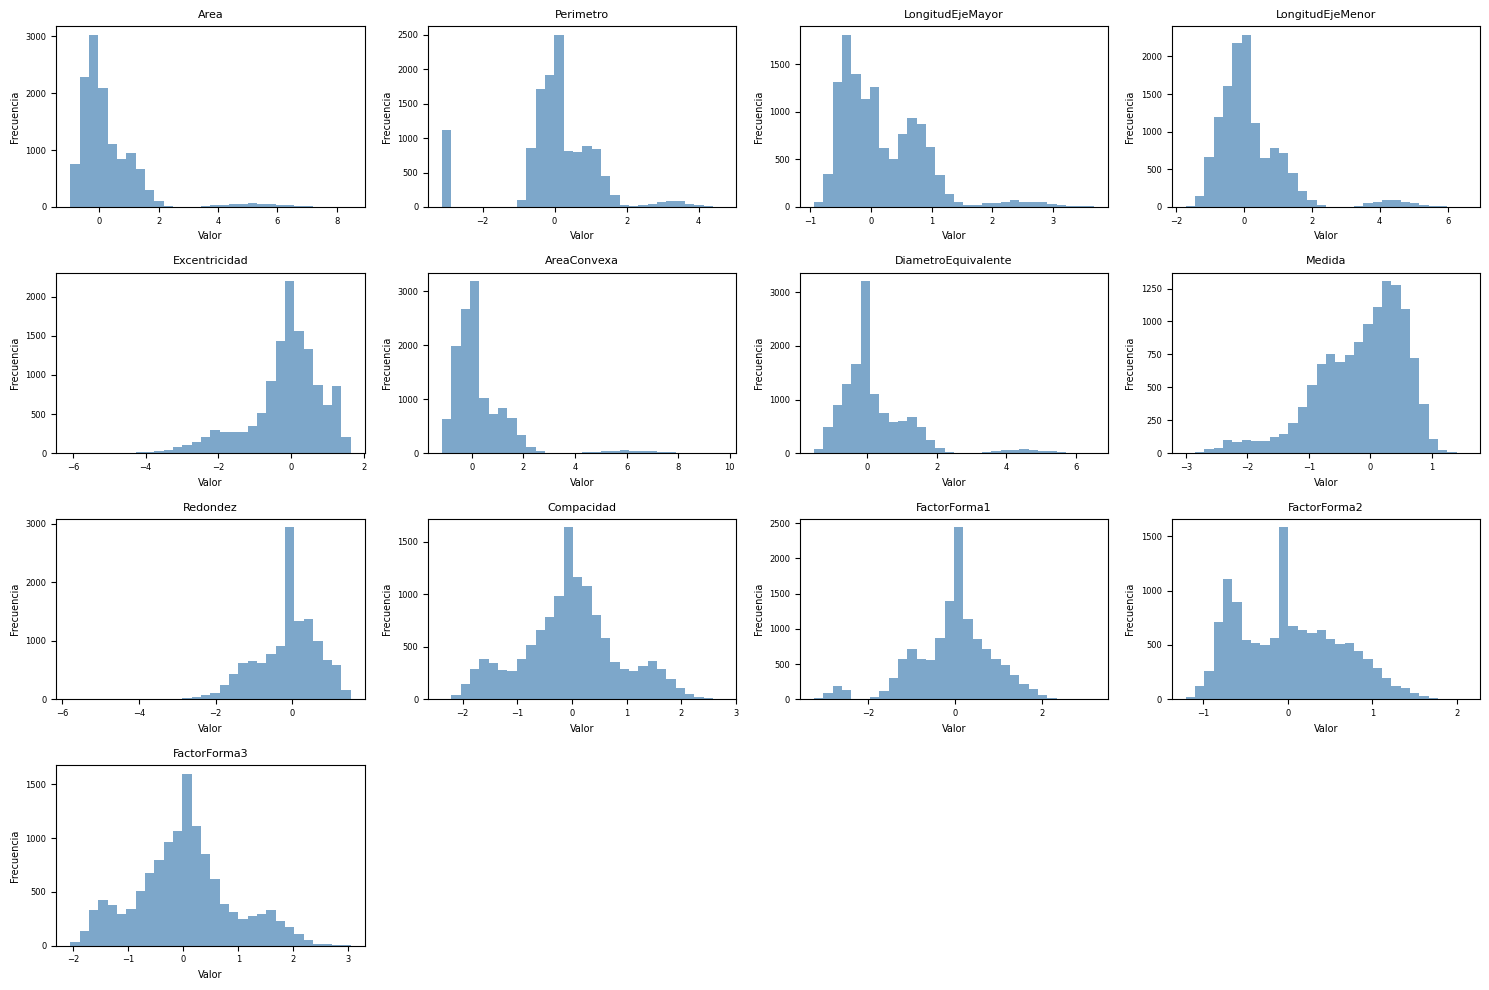

In [35]:
numericas = cleanData.select_dtypes(include=["int64", "float64"])
#  Histogramas para variables numéricas
num_cols = numericas.shape[1]
cols = 4  
rows = (num_cols // cols) + 1

plt.figure(figsize=(15,10))


for i, col in enumerate(numericas.columns, 1):
    plt.subplot(rows, cols, i)
    plt.hist(cleanData[col].dropna(), bins=30, color="steelblue", alpha=0.7)
    plt.title(col, fontsize=8)
    plt.xlabel("Valor", fontsize=7)
    plt.ylabel("Frecuencia", fontsize=7)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

plt.tight_layout()
plt.show()

### Visualización 

- PCA sirve para pasar de muchas dimensiones a pocas (2D o 3D) manteniendo la mayor varianza posible.

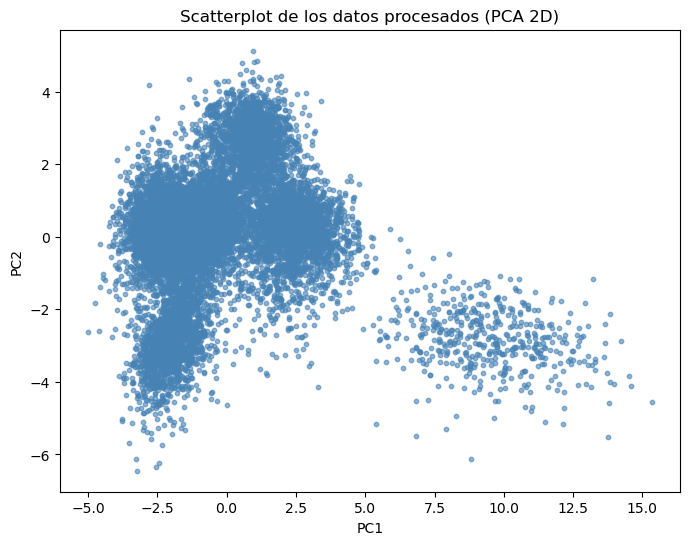

In [36]:
# Quitar columna ID si aún existe
X = cleanData.copy()

# Reducir a 2D con PCA
pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(X)

# Graficar scatterplot
plt.figure(figsize=(8,6))
plt.scatter(XY[:,0], XY[:,1], s=10, alpha=0.6, c="steelblue")
plt.title("Scatterplot de los datos procesados (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## Modelado 

In [37]:
# para posibles pasos extra según el algoritmo.
dataKM = cleanData.copy()


### K-Means

#### Procesamiento extra para k means 


- **Al revisar la correlación de las variables, se identificaron varios grupos de variables altamente correlacionadas:**

  - **Variables de tamaño:**
    - `Área`, `Perímetro`, `LongitudEjeMayor`, `LongitudEjeMenor`, `DiámetroEquivalente`, `ÁreaConvexa`.
    - Decisión: mantener **`Área`** como representativa (resume el resto).
    - Se eliminan: `Perímetro`, `LongitudEjeMayor`, `LongitudEjeMenor`, `DiámetroEquivalente`, `ÁreaConvexa`.

  - **Variables de forma:**
    - Alta correlación entre `Compacidad`, `Excentricidad` y `FactorForma3`.
    - Decisión: mantener **`Excentricidad`** como representativa.
    - Se eliminan: `Compacidad`, `FactorForma3`.

  - **Factores de forma:**
    - `FactorForma1` y `FactorForma2` están correlacionados.
    - Decisión: mantener **`FactorForma2`** como diferenciador.
    - Se elimina: `FactorForma1`.

  - **Otras variables:**
    - `Redondez` y `Solidez` se mantienen, ya que aportan información distinta.
    - Las categóricas (`MétodoSecado_*`, `RelacionAspecto_*`) se mantienen por su relevancia en el negocio y pues porque al ser categóricas obviamente va a haber una correlación.

---

- **Escenario 1 – Eliminación manual:**
  - Conservar el subconjunto reducido de variables seleccionadas (ej. `Área`, `Excentricidad`, `Redondez`, `Solidez`, `FactorForma2`, y las categóricas).
  - Entrenar K-Means y evaluar métricas.

- **Escenario 2 – PCA:**
  - Mantener todas las variables originales.
  - Aplicar PCA (ej. 5 componentes) para reducir redundancia y ruido.
  - Entrenar K-Means sobre las componentes principales y comparar métricas.


---
**Resultados**

- Al comparar los dos escenarios (eliminación manual vs PCA), se observaron diferencias claras en las métricas de validación interna de los clusters:  

  - **Escenario manual:**  
    - Silhouette = 0.404  
    - Calinski–Harabasz = 8662.7  
    - Davies–Bouldin = 0.960  

  - **Escenario PCA: (QUEDÓ COMENTADO PERO ESTÁ AHÍ ABAJO )**  
    - Silhouette = 0.315  
    - Calinski–Harabasz = 7282.5  
    - Davies–Bouldin = 1.059  

- **Interpretación:**  
  - El método manual presentó un **coeficiente de silueta más alto**, lo que indica clusters más compactos y mejor separados.  
  - El índice de Calinski–Harabasz fue mayor, lo que refuerza la idea de mayor cohesión interna y mayor separación entre clusters.  
  - El índice de Davies–Bouldin fue menor, lo cual también señala que los clusters están más diferenciados.  

- **Conclusión:**  
  - A partir de estas métricas, se concluye que el escenario de **eliminación manual de variables redundantes** produjo un mejor desempeño en el clustering.  
  - Esto sugiere que, en este caso, la selección informada de variables resultó más efectiva que aplicar PCA, ya que permitió mantener aquellas características realmente representativas para el problema de negocio.

In [38]:
print(dataKM.columns)

Index(['Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor',
       'Excentricidad', 'AreaConvexa', 'DiametroEquivalente', 'Medida',
       'Redondez', 'Compacidad', 'FactorForma1', 'FactorForma2',
       'FactorForma3', 'RelacionAspecto_alargado',
       'RelacionAspecto_redondeado', 'MétodoSecado_honey',
       'MétodoSecado_lavado', 'MétodoSecado_natural'],
      dtype='object')


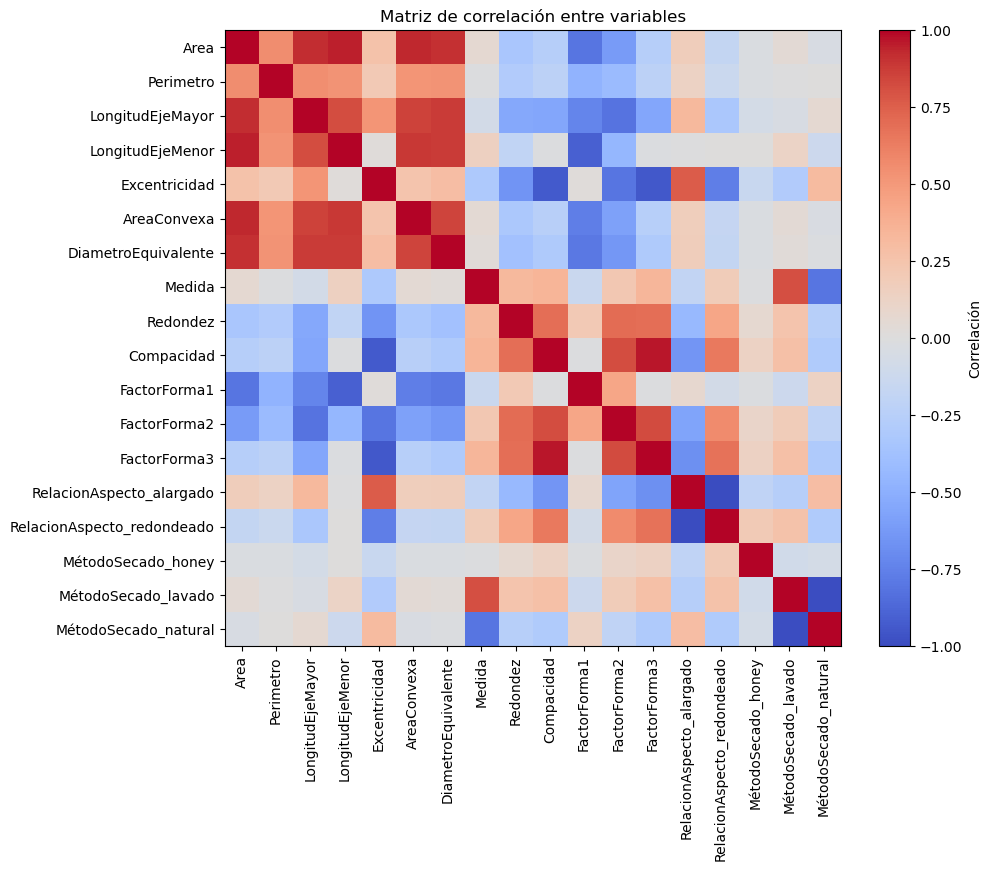

In [39]:
#  Matriz de correlación
corr_matrix = dataKM.corr()

# Mostrar en consola 
#print(corr_matrix)

# 3. Visualizar con heatmap
plt.figure(figsize=(10,8))
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlación")
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.title("Matriz de correlación entre variables")
plt.show()

In [40]:
# Encontrar correlaciones fuertes
umbral = 0.85
corr_matrix = dataKM.corr()

# Guardar pares de variables con correlación alta
corr_pairs = (
    corr_matrix
    .unstack()
    .reset_index()
    .rename(columns={"level_0": "Var1", "level_1": "Var2", 0: "Correlación"})
)

# Filtrar duplicados y la diagonal
corr_pairs = corr_pairs[corr_pairs["Var1"] < corr_pairs["Var2"]]

# Quedarse con las fuertes
corr_fuertes = corr_pairs[abs(corr_pairs["Correlación"]) > umbral]

print("Correlaciones fuertes encontradas:\n")
print(corr_fuertes.sort_values("Correlación", ascending=False))

Correlaciones fuertes encontradas:

                         Var1                        Var2  Correlación
174                Compacidad                FactorForma3     0.961844
3                        Area            LongitudEjeMenor     0.951760
5                        Area                 AreaConvexa     0.932713
2                        Area            LongitudEjeMayor     0.917118
6                        Area         DiametroEquivalente     0.913265
93                AreaConvexa            LongitudEjeMenor     0.888995
110       DiametroEquivalente            LongitudEjeMayor     0.878783
111       DiametroEquivalente            LongitudEjeMenor     0.878384
92                AreaConvexa            LongitudEjeMayor     0.857392
96                AreaConvexa         DiametroEquivalente     0.851503
183              FactorForma1            LongitudEjeMenor    -0.906124
166                Compacidad               Excentricidad    -0.930519
84              Excentricidad            

##### Modelo con eliminación de correlaicón manual 

In [41]:


# Columnas a ELIMINAR por alta correlación (bloque tamaño y forma)
drop_cols = [
    "Perimetro","LongitudEjeMayor","LongitudEjeMenor",
    "DiametroEquivalente","AreaConvexa",
    "Compacidad","FactorForma1","FactorForma3"
]

# Quitar si existen (no falla si falta alguna)
cols_present = [c for c in drop_cols if c in dataKM.columns]
dataKM = dataKM.drop(columns=cols_present).copy()

# 3) garantizar que las que queremos conservar sí estén (evitemos errores)
must_keep = [
    "Area","Excentricidad","Redondez","FactorForma2",
    "RelacionAspecto_alargado","RelacionAspecto_redondeado",
    "MétodoSecado_honey","MétodoSecado_lavado","MétodoSecado_natural"
]
missing = [c for c in must_keep if c not in dataKM.columns]
if missing:
    print("Aviso: faltan en el dataframe (se omiten):", missing)



# K-Means sobre el subset manual (ya escalado previamente)
k = 7
km = KMeans(n_clusters=k, n_init=10, random_state=42)
labels_manual = km.fit_predict(dataKM)

# Métricas
sil = silhouette_score(dataKM, labels_manual)
cal = calinski_harabasz_score(dataKM, labels_manual)
dav = davies_bouldin_score(dataKM, labels_manual)

print(f"[Manual] k={k} | Silhouette={sil:.3f} | Calinski={cal:.1f} | Davies-Bouldin={dav:.3f}")

[Manual] k=7 | Silhouette=0.404 | Calinski=8662.7 | Davies-Bouldin=0.960


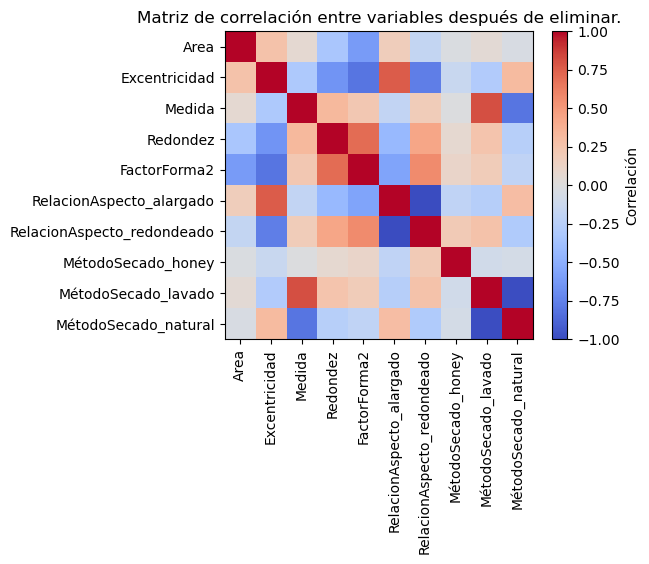

In [42]:
corr_matrix = dataKM.corr()

#  Mostrar en consola 
#print(corr_matrix)

#  Visualizar con heatmap
plt.figure(figsize=(5,4))
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlación")
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.title("Matriz de correlación entre variables después de eliminar.")
plt.show()

##### Modelo con PCA

In [43]:
# # Tomar los features ya escalados en dataKM
# exclude = [c for c in ["ID","Cluster_KMeans"] if c in dataKM.columns]
# X = dataKM.drop(columns=exclude).copy()

# # PCA (95% de la varianza)
# pca_km = PCA(n_components=0.95, random_state=42)
# X_pca = pca_km.fit_transform(X)

# print(f"PCA -> componentes retenidas: {X_pca.shape[1]} | "
#       f"Varianza explicada: {pca.explained_variance_ratio_.sum():.3f}")

# #K-Means
# k = 7
# km_pca = KMeans(n_clusters=k, n_init=10, random_state=42)
# labels_pca = km_pca.fit_predict(X_pca)

# # Métricas
# sil = silhouette_score(X_pca, labels_pca)
# cal = calinski_harabasz_score(X_pca, labels_pca)
# dav = davies_bouldin_score(X_pca, labels_pca)

# print(f"[PCA] k={k} | Silhouette={sil:.3f} | Calinski={cal:.1f} | Davies-Bouldin={dav:.3f}")

#### **Probar el modelo K MEANS**

 

- **Métricas obtenidas Con el hiperparámetro del enunciado (k=7):**
  - Silhouette = 0.404  
  - Calinski–Harabasz = 8662.7  
  - Davies–Bouldin = 0.960  

- **Interpretación técnica:**
  - Un coeficiente de silueta mayor a 0.4 indica que los clusters tienen una separación aceptable, con una cohesión interna adecuada. 
  - El índice de Calinski–Harabasz es alto, lo que confirma que los clusters están bien definidos en términos de compacidad y separación.  
  - El índice de Davies–Bouldin menor a 1 indica que los clusters no se solapan excesivamente.


- **Implicaciones para el negocio del café:**
  - Los granos de café analizados pueden dividirse en **7 grupos con características morfológicas distintas**. No obsante el silhouette dio mejor para k = 6. Esto nos hace pensar que hay dos clases de café muy similares que se diferencian por detalles muy pequeños.  
  - Esta clasificación puede ser utilizada en **control de calidad**, permitiendo identificar de forma automática lotes según sus características específicas.  
  - Finalmente, la agrupación respalda iniciativas de **trazabilidad**, al contar con bases para un sistema automático de identificación que reduzca la dependencia de evaluaciones manuales.  
  - Los resultados tamibén apuntan a que en general en la industria del café, las diferencias entre un tipo y otro son demasiado **sutiles**, y por ello, las caractrísticas tienden a sobrelaparse. 


- **Elbow (Inercia):**
  - La inercia mide la suma de las distancias cuadradas de los puntos a su centroide.
  - El "codo" en la curva indica el punto donde agregar más clusters deja de aportar mejoras significativas.
  - En nuestro caso, el codo aparece alrededor de **k=6 o k=7**, lo que respalda la elección de esos valores.

- **Silhouette:**
  - El coeficiente de silueta mide qué tan simila res son los puntos dentro de un cluster comparados con los de otros clusters.
  - Valores cercanos a 1 indican clusters bien separados y compactos. Valores cercanos a 0 sugieren que los clusters se traslapan.
  - En nuestro análisis, el valor más alto se alcanza en **k=6 (0.414)** y también es aceptable en **k=7 (0.404)**, lo cual confirma que esos son los mejores candidatos.
---

#### Explicación del procedimiento realizado

1. **Preparación de los datos:**  
   Se limpiaron nulos, duplicados y valores negativos. Además, se revisaron correlaciones entre variables y se eliminó redundancia para mantener solo aquellas más representativas.

2. **Escenario 1 (eliminación manual):**  
   Se seleccionó un subconjunto reducido de variables (Área, Excentricidad, Redondez, Solidez, FactorForma2, y las categóricas) para entrenar el modelo, lo que mejoró las métricas frente al uso de todas las variables.

3. **Escenario 2 (PCA):**  
   Se probó una reducción de dimensionalidad usando Componentes Principales (PCA). Aunque PCA eliminó redundancia, en este caso la selección manual produjo mejores resultados.

4. **Evaluación de modelos:**  
   Se entrenaron K-Means con valores de k entre 5 y 10. Las métricas mostraron que k=6 o k=7 eran los valores más adecuados, con k=7 seleccionado como el modelo final.

5. **Visualización de clusters:**  
   Para interpretar los resultados, se redujo la dimensionalidad a 2 componentes principales mediante PCA y se graficaron los clusters junto con los centroides.

---

##### Nota sobre los ejes del gráfico PCA

- En el gráfico de dispersión los ejes corresponden a **PC1** y **PC2**, que son las dos primeras componentes principales obtenidas con PCA.  
- PCA transforma el espacio original de todas las variables en un espacio reducido, donde cada componente es una combinación lineal de las variables originales.  
- PC1 explica la mayor parte de la varianza de los datos, PC2 explica la siguiente mayor proporción, y así sucesivamente.  
- Por tanto, en el gráfico se representa la estructura de los datos en el plano que conserva la mayor información posible, aunque no corresponde directamente a ninguna variable original.

,k,silhouette,calinski_harabasz,davies_bouldin,inertia
0,5,0.357,7964,0.895,16745
1,6,0.414,9134,0.844,12775
2,7,0.404,8663,0.960,11528
3,8,0.346,8091,1.043,10751
4,9,0.321,7702,1.046,10030
5,10,0.322,7450,1.099,9345


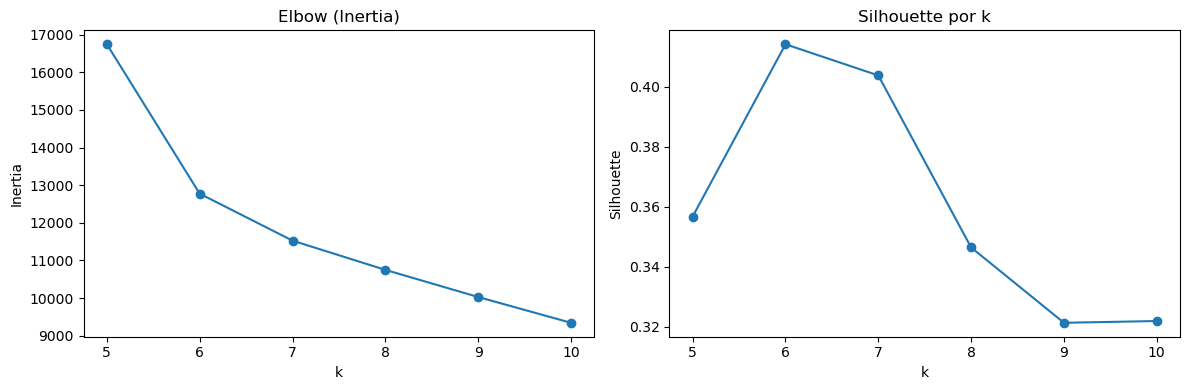

In [44]:
# Probamos diferentes configuraciones para k-Means
X = dataKM.copy()  

k_list = list(range(5, 11))
results = []

for k in k_list:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X)

    sil = silhouette_score(X, labels)
    ch  = calinski_harabasz_score(X, labels)
    db  = davies_bouldin_score(X, labels)

    results.append((k, sil, ch, db, km.inertia_))

res_df = pd.DataFrame(results, columns=["k","silhouette","calinski_harabasz","davies_bouldin","inertia"])
display(res_df.style.format({"silhouette":"{:.3f}", "calinski_harabasz":"{:.0f}", "davies_bouldin":"{:.3f}", "inertia":"{:.0f}"}))

# Curvas (Elbow + Silhouette)
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(res_df["k"], res_df["inertia"], marker="o")
ax[0].set_title("Elbow (Inertia)"); ax[0].set_xlabel("k"); ax[0].set_ylabel("Inertia")

ax[1].plot(res_df["k"], res_df["silhouette"], marker="o")
ax[1].set_title("Silhouette por k"); ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette")

plt.tight_layout(); plt.show()

In [45]:
# Entrenamos el modelo con el k que especifica el enunciado
k_final = 7
kmeans = KMeans(n_clusters=k_final, n_init=20, random_state=42)
labels_k7 = kmeans.fit_predict(X)

dataFinal = cleanData.copy()

dataFinal["Cluster_KMeans"] = labels_k7  # agrega etiquetas al DF base
print("Tamaño por cluster (k=7):")
print(dataFinal["Cluster_KMeans"].value_counts().sort_index())

# Métricas finales
sil_k7 = silhouette_score(X, labels_k7)
ch_k7  = calinski_harabasz_score(X, labels_k7)
db_k7  = davies_bouldin_score(X, labels_k7)
print(f"Silhouette={sil_k7:.3f} | Calinski-Harabasz={ch_k7:.1f} | Davies-Bouldin={db_k7:.3f}")

Tamaño por cluster (k=7):
Cluster_KMeans
0    1532
1    2667
2    2234
3     485
4    1108
5    1444
6    3158
Name: count, dtype: int64
Silhouette=0.404 | Calinski-Harabasz=8662.7 | Davies-Bouldin=0.960


f:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


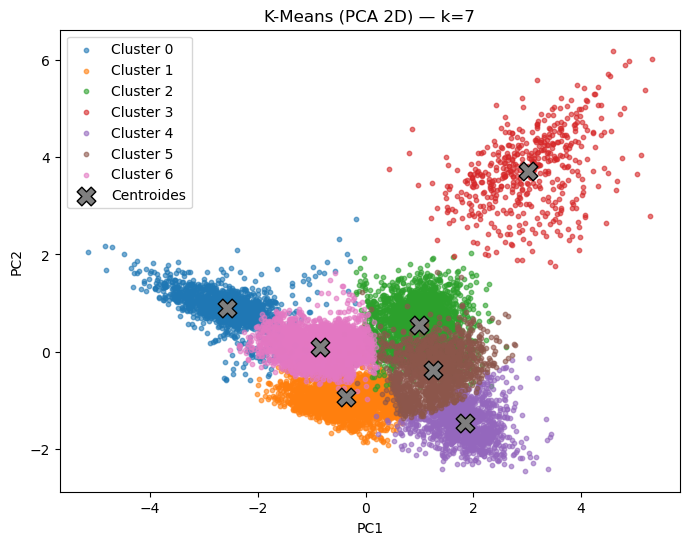

In [46]:
X_for_plot = X 
pca_km_vis = PCA(n_components=2,random_state=42)
XY = pca_km_vis.fit_transform(X_for_plot)
centers_2d = pca_km_vis.transform(kmeans.cluster_centers_)  

labels = labels_k7  # ya calculadas con ese mismo X

plt.figure(figsize=(8,6))
for lab in np.unique(labels):
    mask = labels == lab
    plt.scatter(XY[mask,0], XY[mask,1], s=10, alpha=0.6, label=f"Cluster {lab}")

# centroides
plt.scatter(centers_2d[:,0], centers_2d[:,1], marker="X", s=180,
            edgecolor="k", linewidth=1.0, label="Centroides")

plt.title(f"K-Means (PCA 2D) — k={k_final}")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.show()

### Implementación modelo DBSCAN

1) Resumen ejecutivo

- Algoritmo: DBSCAN el cual indica que es agrupación por densidad.
- Datos: variables morfológicas de granos de café (solo numéricas, tras depurar correlación).
- Mejor configuración probada (actual): eps = 0.7, min_samples = 10.

- Métricas:
    Silhouette (sin filtrar ruido en el código actual): ~0.265
    Calinski–Harabasz: 2129.3
    Davies–Bouldin: 1.528

- clusters sin incluir ruido: 10
- % ruido: ≈ 1.3% (165 de ~12.6k puntos)

Se cuenta con una estructura de clústeres moderada con un coeficiencia de silueta aproximadamente de 0.27, bajo ruido y cierta fragmentación que indican que hay varios clústeres pequeños.

2) Preparación de los datos

- Limpieza general. Se partió de un DataFrame limpio (cleanData), se removieron ID y se trabajó solo con variables numéricas.

- Reducción de correlación. Para evitar que variables muy correlacionadas “inflen” las distancias, se eliminaron columnas redundantes (bloque tamaño/forma), por ejemplo:

- Estandarización 

In [47]:
# Se crea una capia del DataFrame limpio
dataDBSCAN = cleanData.copy()

# Se eliminan las columnas con alta correlación
# Columnas a ELIMINAR por alta correlación (bloque tamaño y forma)
drop_cols = [
    "Perimetro","LongitudEjeMayor","LongitudEjeMenor",
    "DiametroEquivalente","AreaConvexa",
    "Compacidad","FactorForma1","FactorForma3"
]

# Quitar las columnas si existen (no falla si falta alguna)
cols_present = [c for c in drop_cols if c in dataDBSCAN.columns]
dataDBSCAN = dataDBSCAN.drop(columns=cols_present).copy()

# Se garantiza que las columnas importantes estén
must_keep = [
    "Area","Excentricidad","Redondez","FactorForma2",
    "RelacionAspecto_alargado","RelacionAspecto_redondeado",
    "MétodoSecado_honey","MétodoSecado_lavado","MétodoSecado_natural"
]
missing = [c for c in must_keep if c not in dataDBSCAN.columns]
if missing:
    print("Aviso: faltan en el dataframe (se omiten):", missing)

### Evaluación parametros DBSCAN

Resultados DBSCAN:
    eps  min_samples  n_clusters  noise_ratio  silhouette
0   0.3            3         106     0.084099   -0.399327
1   0.3            5          44     0.125673   -0.292020
2   0.3           10          15     0.197339   -0.144276
3   0.5            3          26     0.017818    0.116949
4   0.5            5          13     0.025578    0.239834
5   0.5           10          10     0.040624    0.144380
6   0.7            3          15     0.005543    0.196293
7   0.7            5          11     0.008394    0.265039
8   0.7           10           9     0.013066    0.264587
9   0.8            3          13     0.003564    0.126631
10  0.8            5          10     0.005068    0.204960
11  0.8           10           7     0.008869    0.220843
12  1.0            3          11     0.001901    0.189388
13  1.0            5           8     0.002851    0.219109
14  1.0           10           7     0.003959    0.220746
15  1.5            3           2     0.000871    0.31

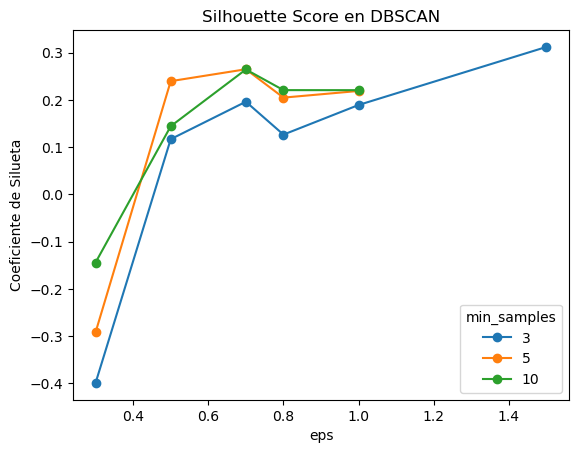

In [48]:
# Probar diferentes configuraciones de DBSCAN
# eps: 0.3, 0.5, 0.7, 0.8, 1.0, 1.5
# min_samples: 3, 5, 10

eps_values = [0.3, 0.5, 0.7, 0.8, 1.0, 1.5]
min_samples_values = [3, 5, 10]

# Resultados para cada combinación
results = []

# Evaluación del modelo con cada configuración
for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(dataDBSCAN)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_ratio = (labels == -1).mean()
        sil = np.nan
        if n_clusters > 1:
            sil = silhouette_score(dataDBSCAN, labels)
        results.append({
        "eps": eps,
        "min_samples": min_samples,
        "n_clusters": n_clusters,
        "noise_ratio": noise_ratio,
        "silhouette": sil,
        })

# Mostrar resultados de siluetas para diferentes eps y min_samples
results_df = pd.DataFrame(results)
print("Resultados DBSCAN:")
print(results_df)


# Gráficar Silhouette por eps para cada min_samples
pivot_eps = results_df.pivot(index="eps", columns="min_samples", values="silhouette")
pivot_eps.plot(marker='o')
plt.title("Silhouette Score en DBSCAN")
plt.ylabel("Coeficiente de Silueta")
plt.xlabel("eps")
plt.show()

### Graficar clusters

Tamaño por cluster (DBSCAN):
cluster_DBSCAN
-1     165
 0    5318
 1    5158
 2    1385
 3      61
 4     334
 5      46
 6      56
 7      89
 8      16
Name: count, dtype: int64
Silhouette=0.265 | Calinski-Harabasz=2129.3 | Davies-Bouldin=1.528


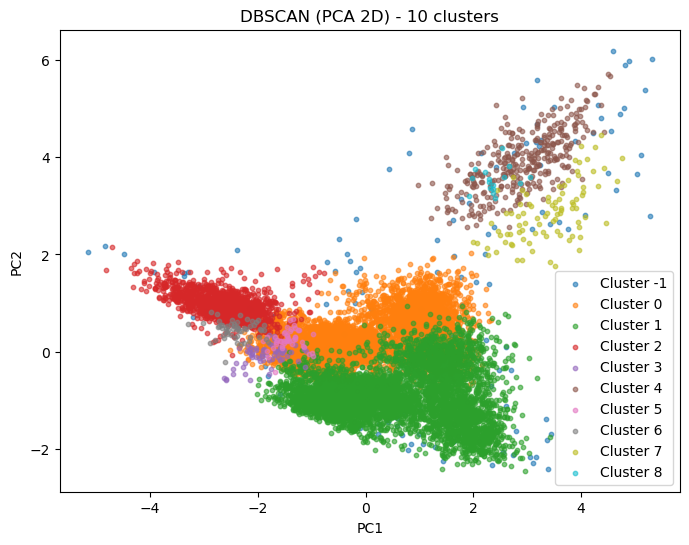

In [49]:
# Se genera el modelo con los mejores hiperparámetros encontrados eps=0.7 y min_samples=10
dbscan = DBSCAN(eps=0.7, min_samples=10) 
X = dataDBSCAN.copy()

# Se ven las etiquetas generadas por el modelo y se agregan al DataFrame original
labelsDB = dbscan.fit_predict(X)
dataFinal["cluster_DBSCAN"] = labelsDB  # agrega etiquetas al DF base
print("Tamaño por cluster (DBSCAN):")
print(dataFinal["cluster_DBSCAN"].value_counts().sort_index())

sil_DBSCAN = silhouette_score(X, labelsDB)
ch_DBSCAN = calinski_harabasz_score(X, labelsDB)
db_DBSCAN = davies_bouldin_score(X, labelsDB)
print(f"Silhouette={sil_DBSCAN:.3f} | Calinski-Harabasz={ch_DBSCAN:.1f} | Davies-Bouldin={db_DBSCAN:.3f}")

labels = labelsDB

X_for_plot = X

# Se hace la reducción a 2D con PCA
pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(X_for_plot)  

# Gráficar los clusters resultantes
plt.figure(figsize=(8,6))
for lab in np.unique(labels):
    mask = labels == lab
    plt.scatter(XY[mask,0], XY[mask,1], s=10, alpha=0.6, label=f"Cluster {lab}")

plt.title(f"DBSCAN (PCA 2D) - {len(np.unique(labels))} clusters")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.show()

### Gaussian Mixture Models (GMM)

**Justificación de la elección del algoritmo:**
- Se elige la implementación del algoritmo GMM porque es adecuado para el dataset con el que se cuenta, un dataset con la mayoría de sus variables númericas que dan registro de características mórficas de los granos de café.
- Asimismo, la intención de esta implementación es ganar flexibilidad en cuanto a las formas de los clusters, ya que algoritmos como K-Means tienen un rendimiento dependiente a la forma esférica de los clusters, es decir, que los datos estén concentrados uniformemente alrededor del centro del cluster. Con esto en mente, GMM permite la identificación de clusters con formas menos restrictas, principalmente, formas elípticas.
- Por último, la elección de este algoritmo se basa también en las métricas que se pueden usar para la elección de los mejores parámetros del modelo. En este orden de ideas, el algoritmo permite calcular métricas estadísticas sólidas sobre los modelos como el AICy el BIC que son más robustas y permiten estabecer un mejor balance entre el ajuste y la complejidad del modelo.
- **Aspectos a considerar**: GMM tiene el supuesto fuerte de que las variables en el dataset usadas para la agrupación siguen distribuciones de probabilidad Gaussianas como, por ejemplo, la distribución normal. Por tal motivo, el rendimiento del algortimo puede verse afectado por la violación de dicho supuesto. 

**Descripción del algoritmo:**
Gaussian Mixture Models (GMM) es un algorimo que modela cada cluster como una distribución de probabilidad conjunta gaussiana con su propia media y matriz de covarianza, lo que permite representar grupos con forma elíptica. El ajuste se alterna entre calcular la probabilidad de pertenencia de cada punto a cada componente y actualizar los parámetros de las gaussianas para maximizar la verosimilitud de las distribuciones muestrales respecto a las teóricas. A diferencia de KMeans, GMM no asigna los puntos de forma rígida, sino que ofrece una probabilidad de pertenencia a cada cluster (OpenAI, 2025).

**Proceso de modelado:**
En general, el proceeso de modelado para GMM se realiza con base en tres pilares fundamentales: 
- La correción de outliers porque el algoritmo es sensible a outliers. 
- La codificiación correcta de variables categóricas porque el algoritmo solo recibe variables numéricascomo input. 
- La consideración de la eliminación de variables con información redundante. El algoritmo se basa en plantear una distribución gaussiana multivariada para cada cluster, con una matriz de covarianzas asociada. Sin embargo, la presencia de variables altamente correlacionadas puede volver dicha matriz inestable y, por ende, los resultados del modelado pueden ser inestables o poco interpretables.

En este orden de ideas, se procede con el modelado.
1. La corrección de outliers ya se cumple con la aplicación del escalamiento robusto en el preprocesamiento de los datos.
2. La codificación adecuada de variables categóricas ya se cumple con el preprocesamiento de los datos.
3. Se entrena primero un modelo de GMM usando todo el datset limpio, sin considerar aun la eliminación de variables correlacionadas. Para elegir un mejor modelo, se prueban varias configuraciones para el número de clusters (empezando desde 2 hasta 10 clusters). Con estas múltiples opciones, se hace un gráfico Elbow con base en el criterio del AIC y, además, se grafica el coeficiente de silueta alcanzado para cada configuración. Con base en esto, se elige el modelo con el coeficiente de silueta mayor y, para afianzar la elección, se analiza que el número de de clusters elegido se encuentre en la zona del codo de la gráfica Elbow con AIC. Además, teniendo en cuenta que el dataset cuenta con 7 variedades de café, se ignora el clustering con 2 grupos porque no tiene un aporte considerable a la consecución de los objetivos de negocio. De este modo, se obtienen los siguientes resultados:
  - n = 6.
  - Coeficiente de silueta = 0.121.
  - La configuración con n=6 se encuentra en la zona del codo de la gráfica del AIC, pues configuraciones con un mayor número de clústers no aporta considerablemente a la disminución del AIC.
4. Se procede a eliminar las variables altamente correlacionadas con el fin de obtener una posible mejora en el rendimiento del algoritmo. En este orden de ideas, al igual que para K-Means, se eliminan las variables con dos métodos: eliminación manual y PCA. 
  - **Eliminación manual**: La selección de variables a eliminar se basa nuevamente en los argumentos dados en la eliminación de variables para K-Means. Con base en esta eliminación de variables, se obtienen los siguientes resultados:
    - n = 5.
    - Coeficiente de silueta = 0.341.
    - La configuración con n = 5 se ubica en la zona del codo del gráfico del AIC para los modelos entrenados. En este orden de ideas, configuraciones con un mayor número de clusters pierden el buen rendimiento en cuanto al coeficiente de silueta, pero no mejoran considerablemente el AIC.
    
  - **PCA**: Al igual que en K-Means, el algoritmo se basa en concentrar la información de las variables en sus componentes principales para reducir la redundancia de información. De esta forma, se obtienen los siguientes resultados:
    - n = 5.
    - Coeficiente de silueta = 0.481.
    - La configuración con n = 5 es exactamente el codo, con claridad, del gráfico para el AIC. En este punto, el AIC converge y deja de tener cambios significativos.
5. Con base en los algoritmos entrenados, se elige el coeficiente de silueta para seleccionar el mejor modelo. De este modo, al tener en cuenta que se busca siempre maximizar el coeficiente de silueta, el mejor modelo hallado para GMM es el modelo entrenado con el dataset que no contiene información redundante eliminada mediante PCA.
6. Resultados del mejor modelo:
  - El mejor modelo hallado corresponde al modelo entrenado con el dataset transformado por PCA.
  - Coeficiente de silueta = 0.481. El método manual presentó un **coeficiente de silueta más alto**, lo que indica clusters más compactos y mejor separados.  
  - Índice Calinski-Harabasz = 17605.2. El índice de Calinski–Harabasz fue mayor, lo que refuerza la idea de mayor cohesión interna y mayor separación entre clusters.  
  - Índice Davies-Bouldin = 0.606.El índice de Davies–Bouldin fue menor, lo cual también señala que los clusters están más diferenciados.
7. **Implicaciones para SenecaféAlpes:**
- El mejor clustering se alcanza seleccionando 5 clusters. Por tal motivo, sí hay patrones reales entre las características de los granos de café, por lo que, las variedades del mismo sí son reales. Sin embargo, solo hay 5 agrupaciones relevantes según el modelo, por lo que, la empresa puede esar perdiendo esfuerzos y recursos en sacar 2 tipos de variedades que realmente no tienen diferencias significativas con otras variedades.
- Con estos resultados, la empresa puede usar el modelo para la automatización de la clasificación de los granos de café en cada variedad, detectar granos de café atípicos y concentrar los recursos y estrategias en la definición de segmentos de mercado con base en variedades reales de los granos de café (solo 5, no 7).
8. **Uso de IA:** 
Se hizo uso de inteligencia artifical en este modelo para el entendimiento de cómo funciona y qué hace el algoritmo GMM para clustering. Asimismo, se usó para obtener un código base en python para usar adecuadamente la librería que soporta la implementación del modelo.  
  

In [50]:
#Se crea una copia del dataset para usar en el modelado de GMM.
dataGM = cleanData.copy()

,n,silhouette,AIC
0,2,0.233,-429653
1,3,0.122,-587485
2,4,0.073,-673642
3,5,0.077,-698425
4,6,0.121,-740216
5,7,0.070,-784821
6,8,-0.000,-810784
7,9,0.082,-837082
8,10,0.054,-870204


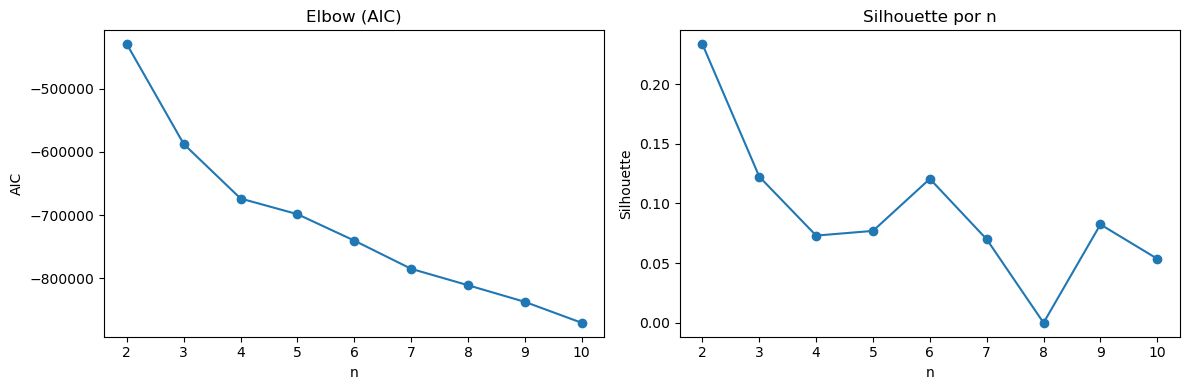

In [51]:

#Se prueban distintos números de clusters para el modelo usando el dataset completo.
n_components = range(2, 11)
results = []

#Se usa el criterio de AIC de los modelos para hacer el gráfico elbow.
for n in n_components:
    gmm = GaussianMixture(n, random_state=42).fit(dataGM)
    labels = gmm.predict(dataGM)

    sil = silhouette_score(dataGM, labels)

    results.append((n, sil, gmm.aic(dataGM)))

res_df = pd.DataFrame(results, columns=["n","silhouette","AIC"])
display(res_df.style.format({"silhouette":"{:.3f}", "AIC":"{:.0f}"}))

# Curvas (Elbow + Silhouette)
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(res_df["n"], res_df["AIC"], marker="o")
ax[0].set_title("Elbow (AIC)"); ax[0].set_xlabel("n"); ax[0].set_ylabel("AIC")

ax[1].plot(res_df["n"], res_df["silhouette"], marker="o")
ax[1].set_title("Silhouette por n"); ax[1].set_xlabel("n"); ax[1].set_ylabel("Silhouette")

plt.tight_layout(); plt.show()

In [52]:
# Columnas a ELIMINAR por alta correlación (bloque tamaño y forma)
drop_cols = [
    "Perimetro","LongitudEjeMayor","LongitudEjeMenor",
    "DiametroEquivalente","AreaConvexa",
    "Compacidad","FactorForma1","FactorForma3"
]

# Quitar si existen (no falla si falta alguna)
cols_present = [c for c in drop_cols if c in dataGM.columns]
dataGM = dataGM.drop(columns=cols_present).copy()

# 3) garantizar que las que queremos conservar sí estén (evitemos errores)
must_keep = [
    "Area","Excentricidad","Redondez","FactorForma2",
    "RelacionAspecto_alargado","RelacionAspecto_redondeado",
    "MétodoSecado_honey","MétodoSecado_lavado","MétodoSecado_natural"
]
missing = [c for c in must_keep if c not in dataGM.columns]
if missing:
    print("Aviso: faltan en el dataframe (se omiten):", missing)

,n,silhouette,AIC
0,2,0.360,-459692
1,3,0.320,-604468
2,4,0.277,-617366
3,5,0.341,-623448
4,6,0.308,-634004
5,7,0.232,-652719
6,8,0.214,-664779
7,9,0.262,-643086
8,10,0.192,-650073


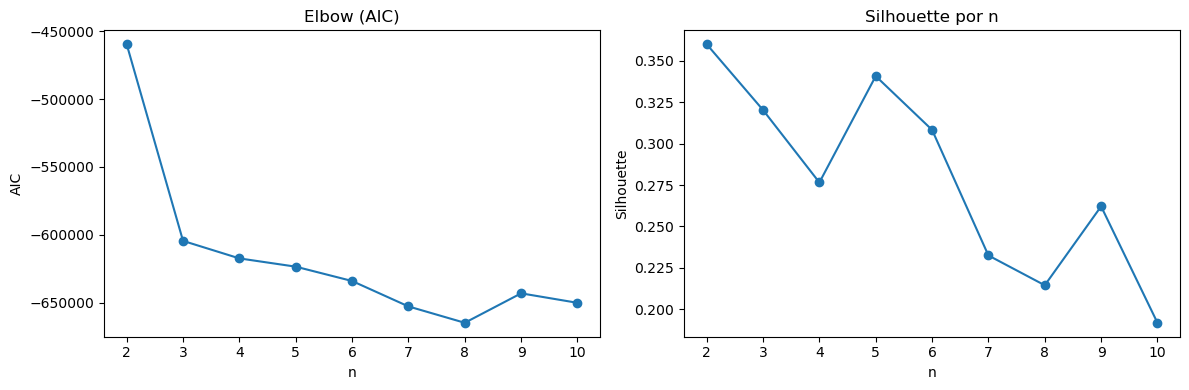

In [53]:

#Se prueban distintos números de clusters para el modelo usando el dataset completo.
n_components = range(2, 11)
results = []

#Se usa el criterio de AIC de los modelos para hacer el gráfico elbow.
for n in n_components:
    gmm = GaussianMixture(n, random_state=42).fit(dataGM)
    labels = gmm.predict(dataGM)

    sil = silhouette_score(dataGM, labels)

    results.append((n, sil, gmm.aic(dataGM)))

res_df = pd.DataFrame(results, columns=["n","silhouette","AIC"])
display(res_df.style.format({"silhouette":"{:.3f}", "AIC":"{:.0f}"}))

# Curvas (Elbow + Silhouette)
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(res_df["n"], res_df["AIC"], marker="o")
ax[0].set_title("Elbow (AIC)"); ax[0].set_xlabel("n"); ax[0].set_ylabel("AIC")

ax[1].plot(res_df["n"], res_df["silhouette"], marker="o")
ax[1].set_title("Silhouette por n"); ax[1].set_xlabel("n"); ax[1].set_ylabel("Silhouette")

plt.tight_layout(); plt.show()

In [54]:
#Se crea una copia del dataset para usar en el modelado de GMM.
X_pca = cleanData.copy()
pca_gmm = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_pca)

,n,silhouette,AIC
0,2,0.448,103682
1,3,0.467,99594
2,4,0.458,96747
3,5,0.481,95938
4,6,0.449,95621
5,7,0.401,95646
6,8,0.405,95661
7,9,0.390,95663
8,10,0.371,95433


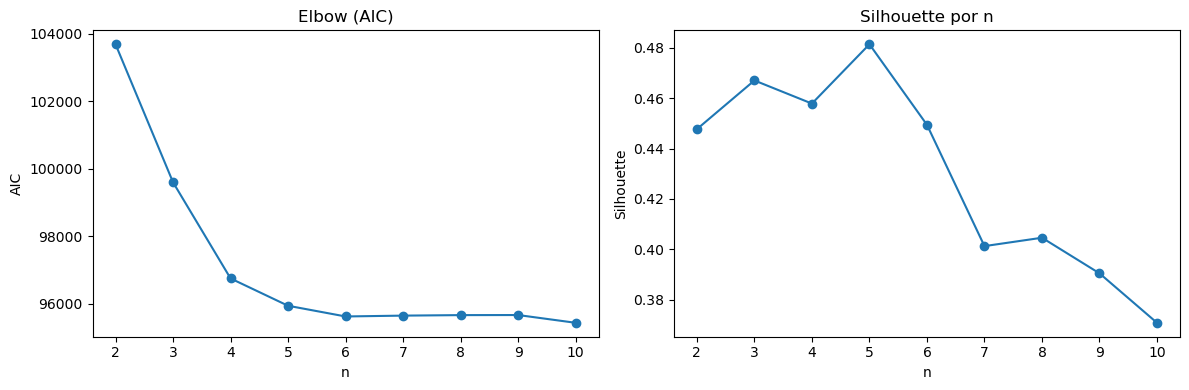

In [55]:

#Se prueban distintos números de clusters para el modelo usando el dataset completo.
n_components = range(2, 11)
results = []

#Se usa el criterio de AIC de los modelos para hacer el gráfico elbow.
for n in n_components:
    gmm = GaussianMixture(n, random_state=42).fit(X_pca)
    labels = gmm.predict(X_pca)

    sil = silhouette_score(X_pca, labels)

    results.append((n, sil, gmm.aic(X_pca)))

res_df = pd.DataFrame(results, columns=["n","silhouette","AIC"])
display(res_df.style.format({"silhouette":"{:.3f}", "AIC":"{:.0f}"}))

# Curvas (Elbow + Silhouette)
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(res_df["n"], res_df["AIC"], marker="o")
ax[0].set_title("Elbow (AIC)"); ax[0].set_xlabel("n"); ax[0].set_ylabel("AIC")

ax[1].plot(res_df["n"], res_df["silhouette"], marker="o")
ax[1].set_title("Silhouette por n"); ax[1].set_xlabel("n"); ax[1].set_ylabel("Silhouette")

plt.tight_layout(); plt.show()

In [56]:
#Se prueba el primer modelo usando el número de clusters dado por Elbow con AIC y el coeficiente de silueta.
gmm = GaussianMixture(n_components=5, random_state=42)  # n_components = número de clusters
X = X_pca
gmm.fit(X)

#Predicciones de clusters
labels = gmm.predict(X)
dataFinal['cluster_GMM'] = labels

#Métricas finales
print("Tamaño por cluster (k=5):")
print(dataFinal["cluster_GMM"].value_counts().sort_index())

# Métricas finales
sil_k5 = silhouette_score(X, labels)
ch_k5  = calinski_harabasz_score(X, labels)
db_k5  = davies_bouldin_score(X, labels)
print(f"Silhouette={sil_k5:.3f} | Calinski-Harabasz={ch_k5:.1f} | Davies-Bouldin={db_k5:.3f}")

Tamaño por cluster (k=5):
cluster_GMM
0    1778
1    1830
2     491
3    6008
4    2521
Name: count, dtype: int64
Silhouette=0.481 | Calinski-Harabasz=17605.2 | Davies-Bouldin=0.606


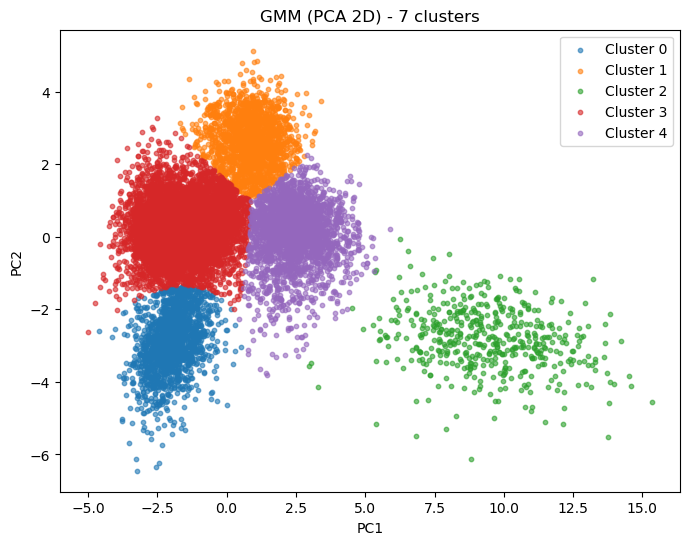

In [57]:
pca_gmm_vis = PCA(n_components=2,random_state=42)
XY = pca_gmm_vis.fit_transform(X_pca)
plt.figure(figsize=(8,6))
for lab in np.unique(labels):
    mask = labels == lab
    plt.scatter(XY[mask,0], XY[mask,1], s=10, alpha=0.6, label=f"Cluster {lab}")

plt.title(f"GMM (PCA 2D) - 7 clusters")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.show()

### Resultados

Al comparar el mejor modelo hallado para cada algoritmo, se concluye que el mejor modelo, al usar el coeficiente de silueta como criterio, es el que se obtuvo con GMM usando PCA para transformar el dataset. En este orden de ideas, para completar la validación cuantitativa hecha para el modelo mencionado, se procede a hacer la validación cualititativa mediante la exploración gráfica y analítica de los datos presentes en cada cluster. Este proceso se realiza con base en el artículo recomendado "Best Practices for Visualizing Your Cluster Results".

**Dataset**

In [165]:
dataFinal.head()

,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,RelacionAspecto_alargado,RelacionAspecto_redondeado,MétodoSecado_honey,MétodoSecado_lavado,MétodoSecado_natural,Cluster_KMeans,cluster_GMM
0,0.251941,0.615184,0.514916,-0.269967,0.000000,0.000000,0.312239,0.659149,-1.976738,-1.353080,0.342034,-0.628798,-1.262523,True,False,False,True,False,2,1
1,0.732342,0.940065,0.935960,0.144086,0.000000,0.898789,0.869489,-0.820638,-1.477697,-1.631125,-0.106116,-0.828583,-1.502894,True,False,False,False,True,5,1
2,0.619612,0.901553,0.768857,0.135216,1.077073,0.745587,0.743849,-1.443512,-1.779701,-1.345291,-0.132352,-0.719691,-1.255697,True,False,False,False,True,4,1
3,0.421056,-3.124958,0.687943,-0.172164,1.205773,0.494699,0.000000,0.584739,-0.910826,-1.527824,0.207779,-0.730204,-1.414344,True,False,False,True,False,2,1
4,-0.211706,-0.138134,-0.282412,-0.030745,-0.877456,-0.252114,-0.291856,0.227843,0.360371,0.756816,0.025190,0.513429,0.771873,True,False,False,True,False,6,3


**Boxplots**

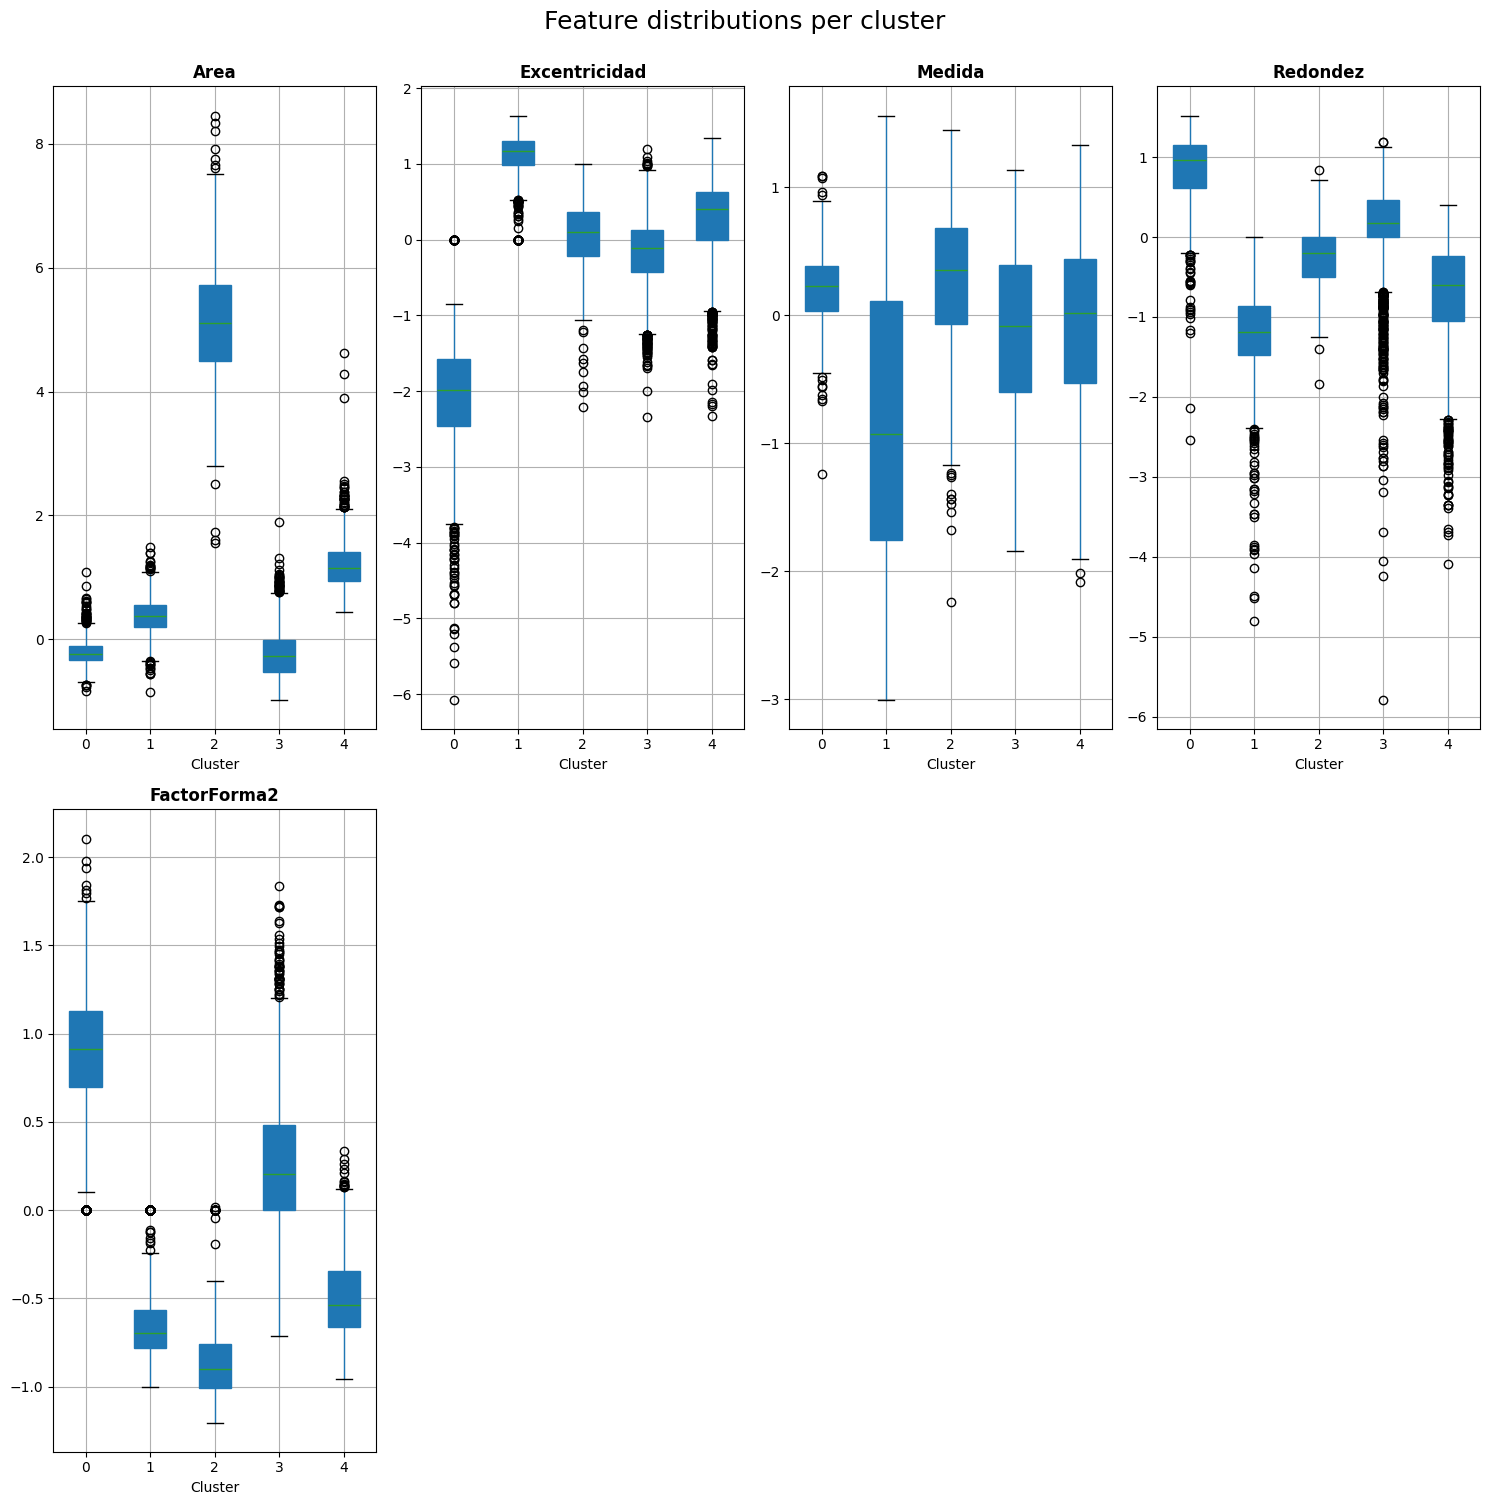

In [177]:
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
cat_cols = list(dataFinal.select_dtypes(include=['bool']))
X = dataFinal.drop(columns=['Cluster_KMeans',"Perimetro","LongitudEjeMayor","LongitudEjeMenor",
    "DiametroEquivalente","AreaConvexa",
    "Compacidad","FactorForma1","FactorForma3"]+cat_cols)
features = X.drop(columns=['cluster_GMM']).columns
ncols = 4
nrows = len(features) // ncols + (len(features) % ncols > 0)
fig = plt.figure(figsize=(15,15))

for n, feature in enumerate(features):
    ax = plt.subplot(nrows, ncols, n + 1)
    X.boxplot(column=feature, by='cluster_GMM', ax=ax, patch_artist=True)
    ax.set_xlabel('Cluster')
    ax.set_title(feature, fontweight="bold")

fig.suptitle('Feature distributions per cluster', fontsize=18, y=1)   
plt.tight_layout()
plt.show()

In [178]:

X_mean = pd.concat([pd.DataFrame(X.mean().drop('cluster_GMM'), columns=['mean']), 
                   X.groupby('cluster_GMM').mean().T], axis=1)

X_dev_rel = X_mean.apply(lambda x: round((x-x['mean'])/x['mean'],2)*100, axis = 1)
X_dev_rel.drop(columns=['mean'], inplace=True)
X_mean.drop(columns=['mean'], inplace=True)

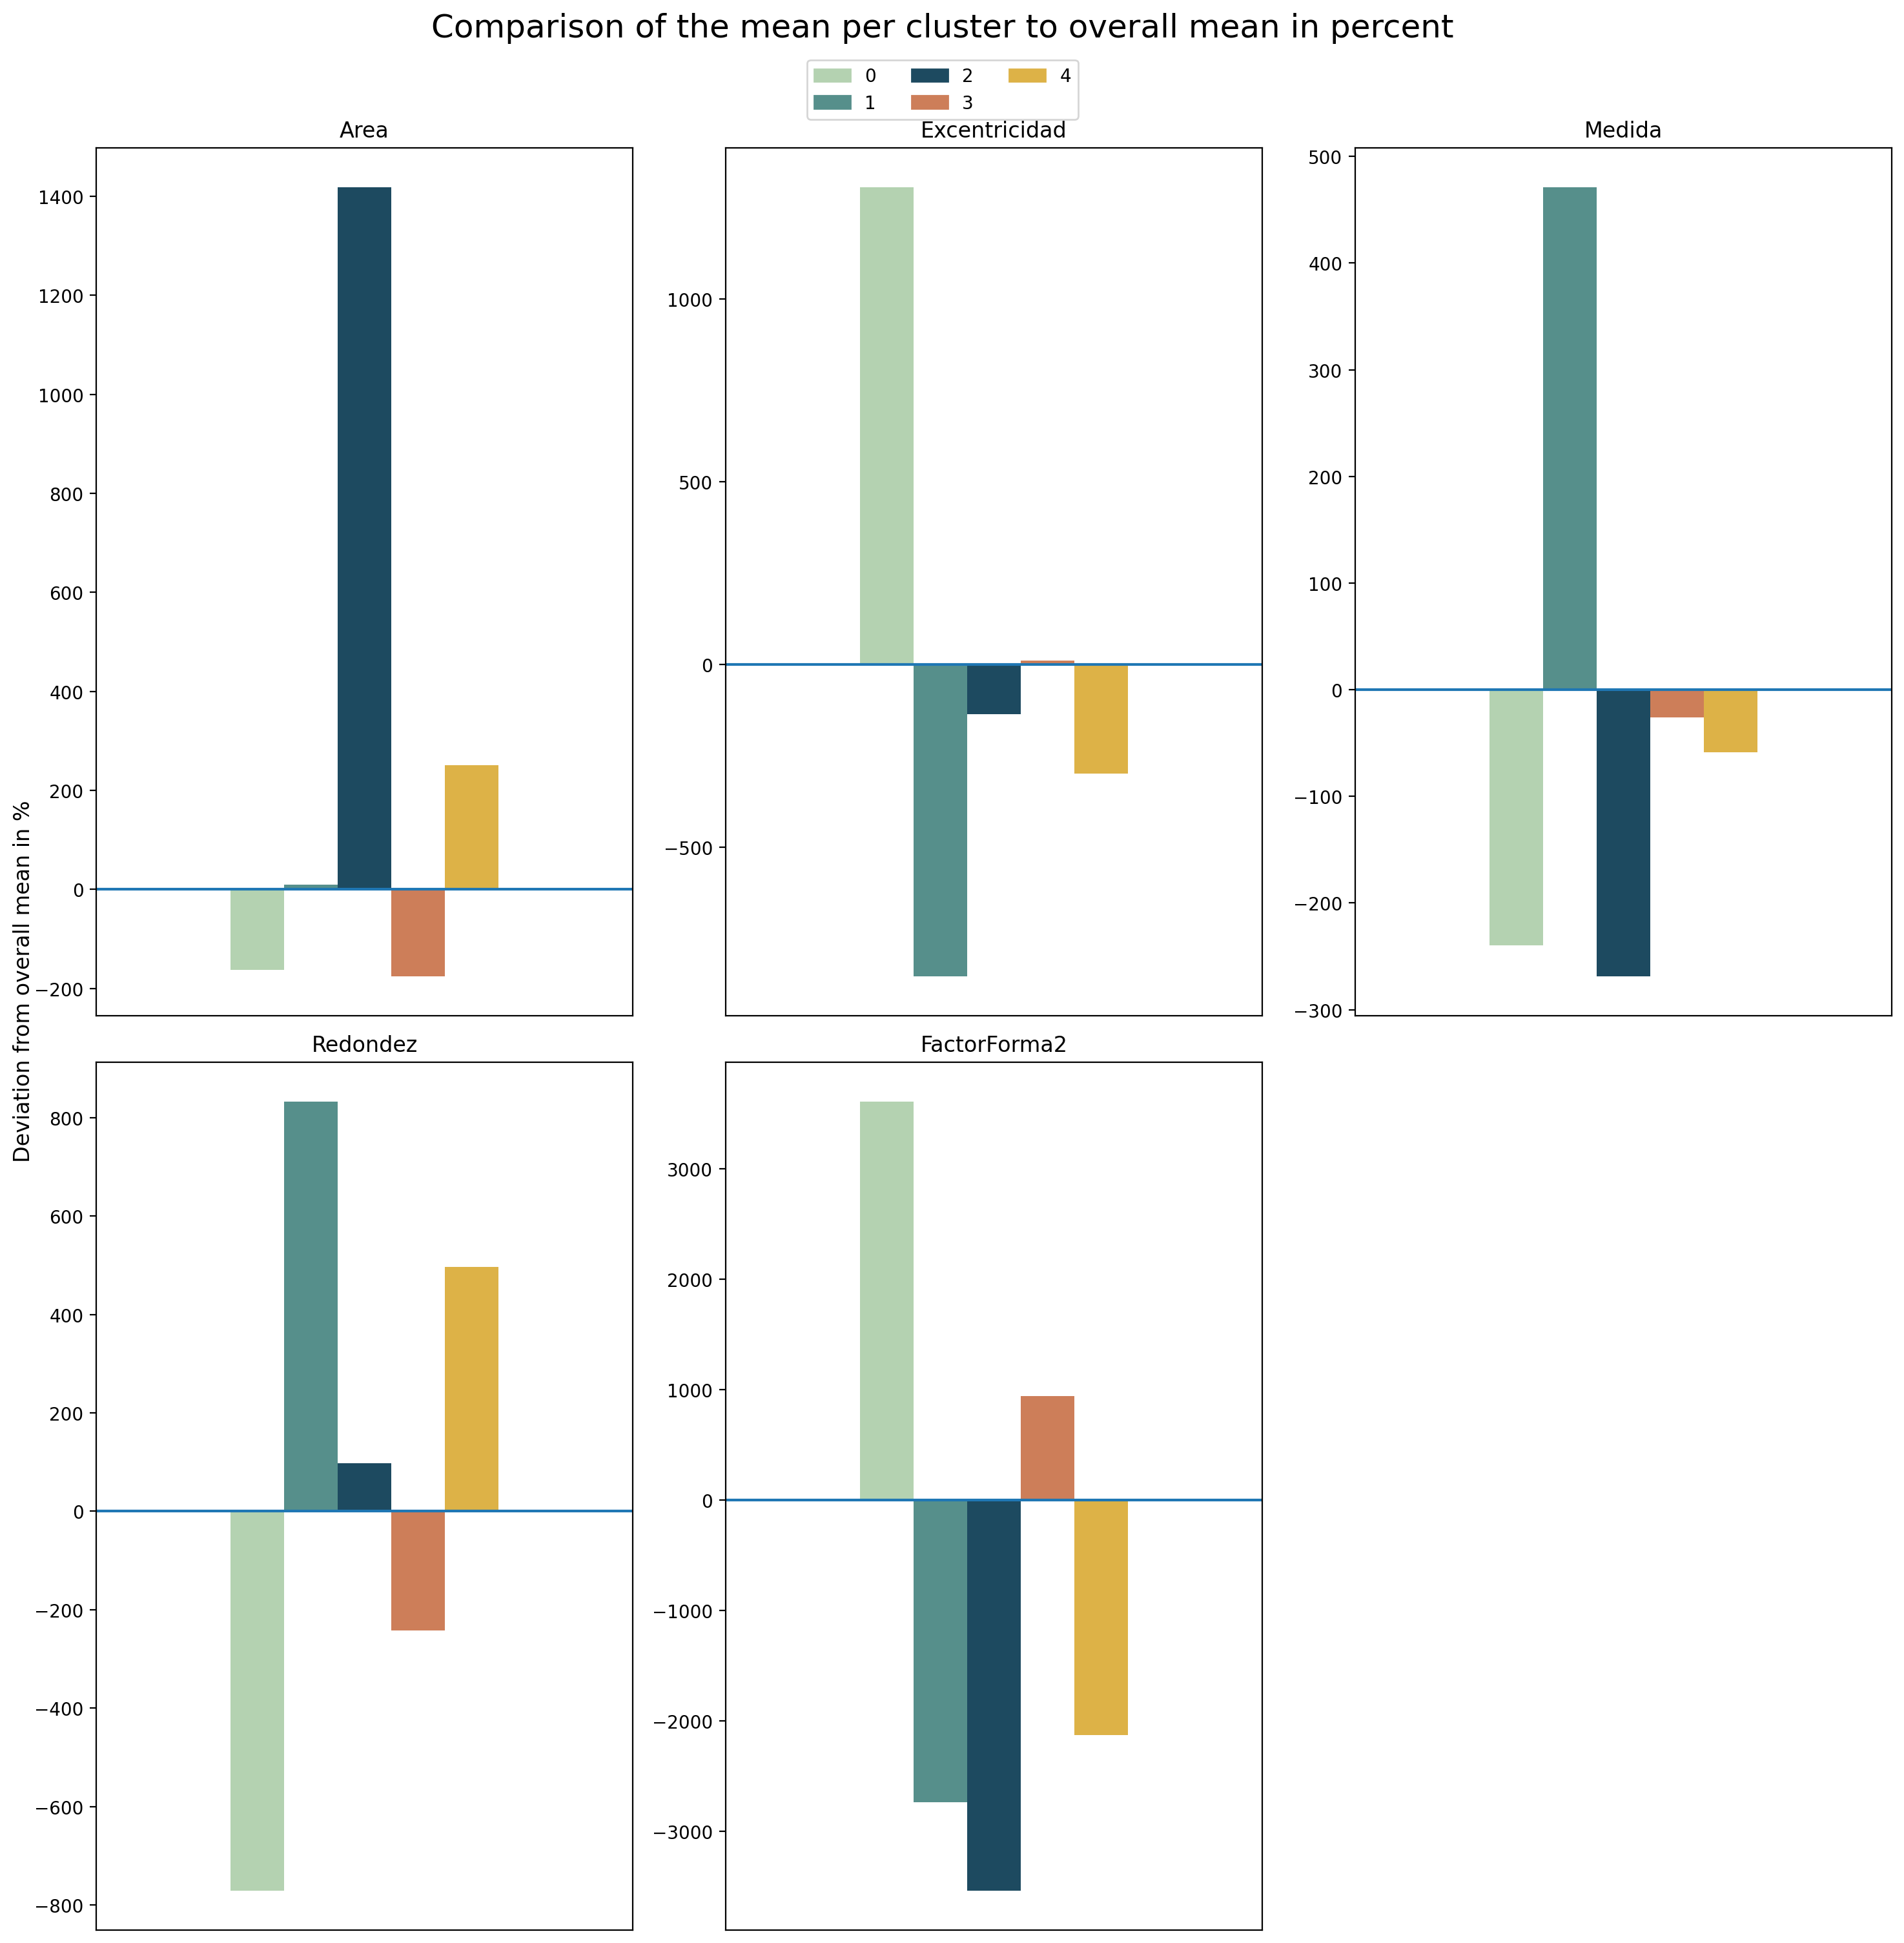

In [181]:
import matplotlib.patches as mpatches
def cluster_comparison_bar(X_comparison, colors, deviation=True ,title="Cluster results"):
    
    features = X_comparison.index
    ncols = 3
    # calculate number of rows
    nrows = len(features) // ncols + (len(features) % ncols > 0)
    # set figure size
    fig = plt.figure(figsize=(15,15), dpi=200)
    #interate through every feature
    for n, feature in enumerate(features):
        # create chart
        ax = plt.subplot(nrows, ncols, n + 1)
        X_comparison[X_comparison.index==feature].plot(kind='bar', ax=ax, title=feature, 
                                                             color=colors[0:X.cluster_GMM.nunique()],
                                                             legend=False
                                                            )
        plt.axhline(y=0)
        x_axis = ax.axes.get_xaxis()
        x_axis.set_visible(False)

    c_labels = X_comparison.columns.to_list()
    c_colors = colors[0:3]
    mpats = [mpatches.Patch(color=c, label=l) for c,l in list(zip(colors[0:X.cluster_GMM.nunique()],
                                                                  X_comparison.columns.to_list()))]

    fig.legend(handles=mpats,
               ncol=ncols,
               loc="upper center",
               fancybox=True,
               bbox_to_anchor=(0.5, 0.98)
              )
    axes = fig.get_axes()
    
    fig.suptitle(title, fontsize=18, y=1)
    fig.supylabel('Deviation from overall mean in %')
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
cluster_comparison_bar(X_dev_rel, cluster_colors, title="Comparison of the mean per cluster to overall mean in percent")

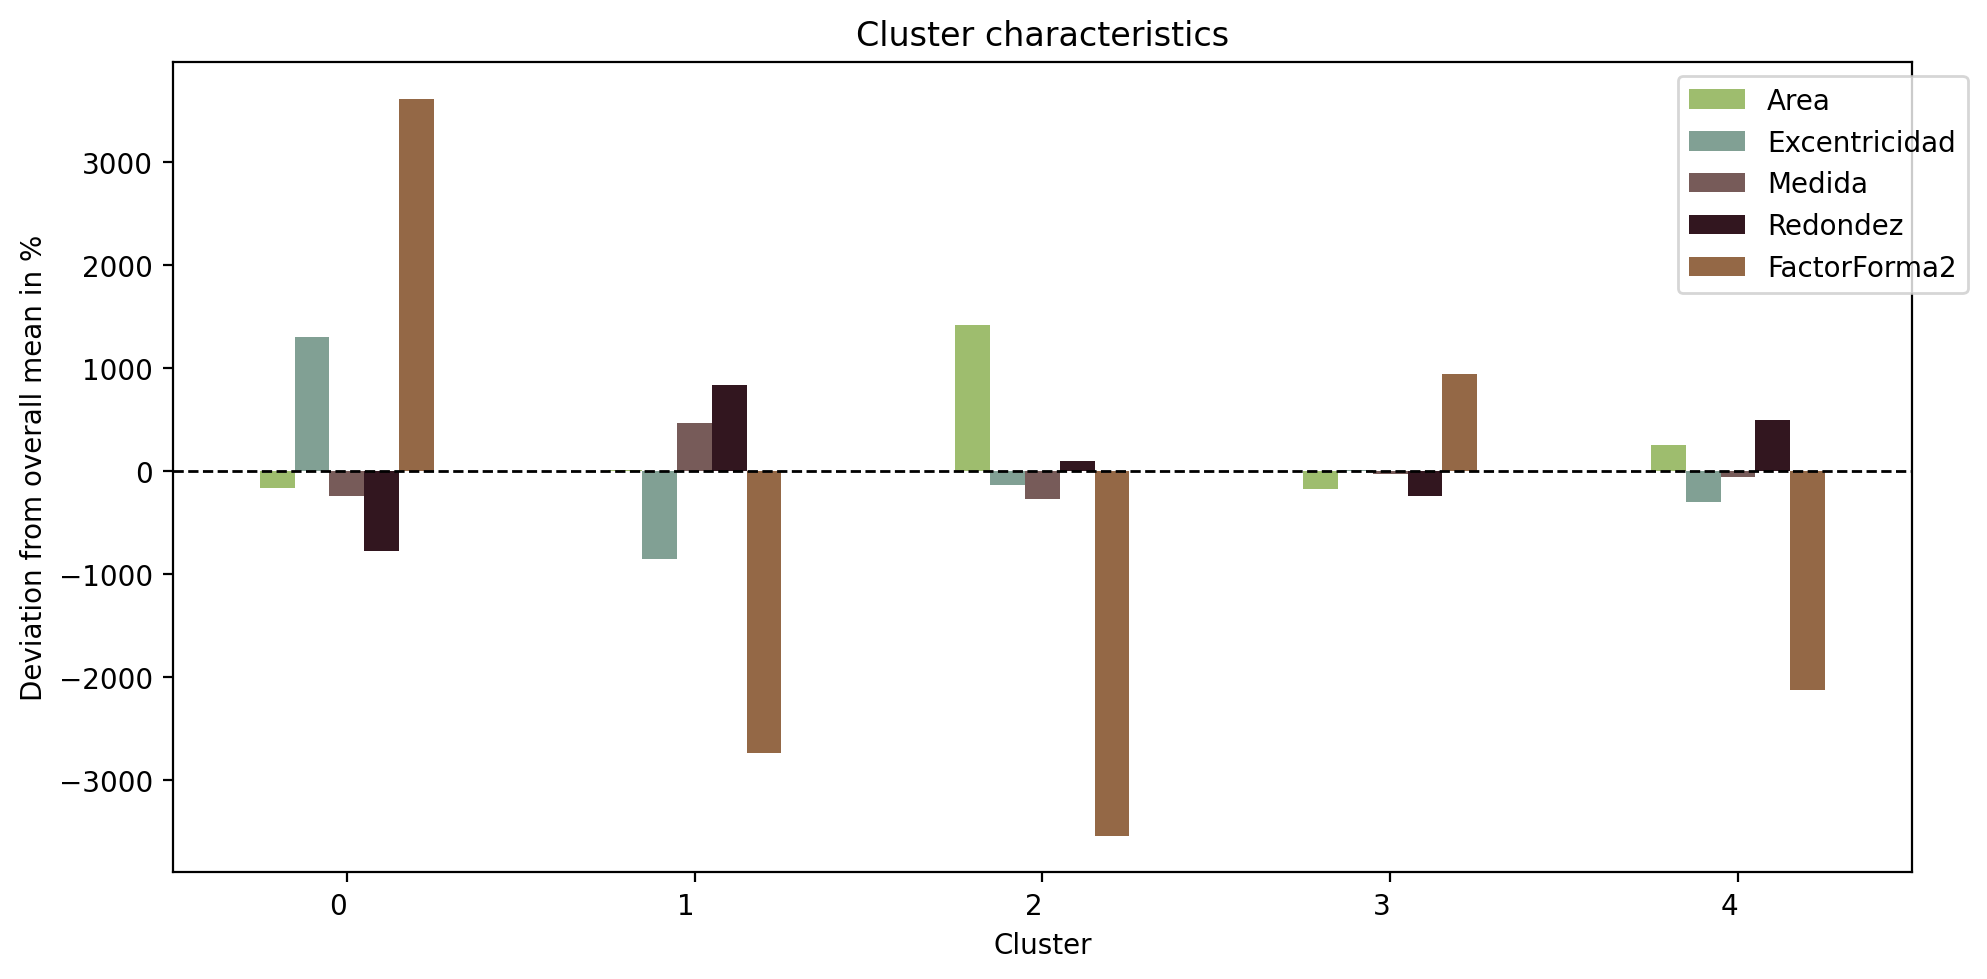

In [182]:

colors = ['#9EBD6E','#81a094','#775b59','#32161f', '#946846', '#E3C16F', '#fe938c', '#E6B89C','#EAD2AC',
          '#DE9E36', '#4281A4','#37323E','#95818D'
         ]

fig = plt.figure(figsize=(10,5), dpi=200)
X_dev_rel.T.plot(kind='bar', 
                       ax=fig.add_subplot(), 
                       title="Cluster characteristics", 
                       color=colors,
                       xlabel="Cluster",
                       ylabel="Deviation from overall mean in %"
                      )
plt.axhline(y=0, linewidth=1, ls='--', color='black')
plt.legend(bbox_to_anchor=(1.04,1))
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

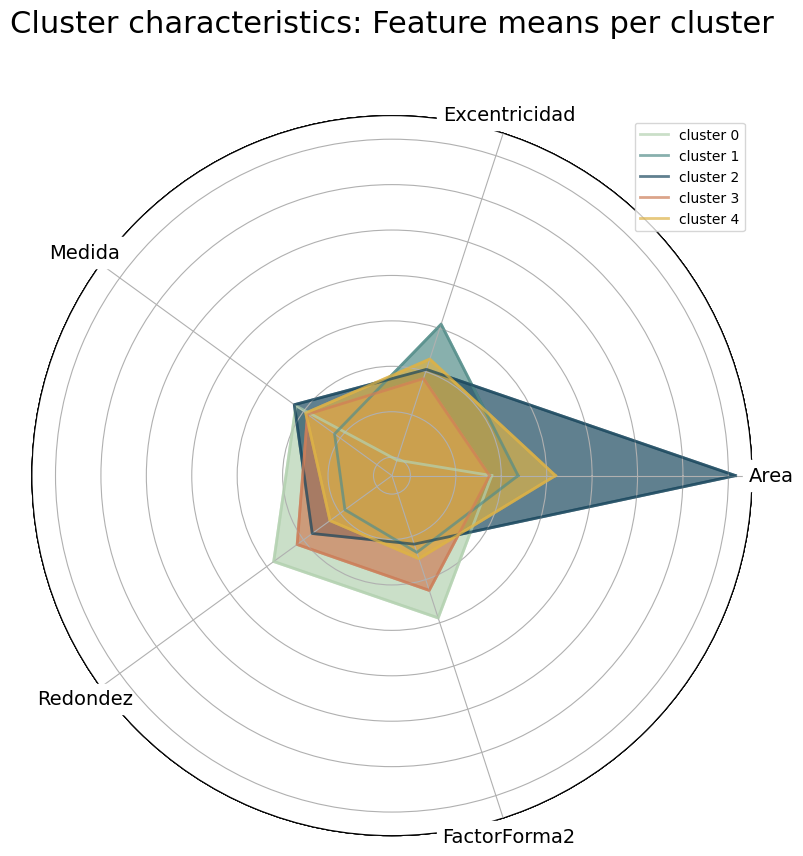

In [184]:
class Radar(object):
    def __init__(self, figure, title, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.9, 0.9]

        self.n = len(title)
        self.angles = np.arange(0, 360, 360.0/self.n)
        
        self.axes = [figure.add_axes(rect, projection='polar', label='axes%d' % i) for i in range(self.n)]
        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=title, fontsize=14, backgroundcolor="white",zorder=999) # Feature names
        self.ax.set_yticklabels([])
        
        for ax in self.axes[1:]:
            ax.xaxis.set_visible(False)
            ax.set_yticklabels([])
            ax.set_zorder(-99)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.spines['polar'].set_color('black')
            ax.spines['polar'].set_zorder(-99)
                     
    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)
        kw['label'] = '_noLabel'
        self.ax.fill(angle, values,*args,**kw)

fig = plt.figure(figsize=(8, 8))
no_features = len(features)
radar = Radar(fig, features, np.unique(X['cluster_GMM']))

for k in range(0,5):
    cluster_data = X_mean[k].values.tolist()
    radar.plot(cluster_data,  '-', lw=2, color=cluster_colors[k], alpha=0.7, label='cluster {}'.format(k))

radar.ax.legend()
radar.ax.set_title("Cluster characteristics: Feature means per cluster", size=22, pad=60)
plt.show()